In [1]:
import os
os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/experiments')
# # os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/experiments/')
# from multi_world_experiment import MultiWorldExperiment

# experiment = MultiWorldExperiment(
#     seq_len=100,
#     prefix_len=50, 
#     forecast_horizon=40
# )

# results = experiment.run_experiment(
#     n_samples=100,
#     n_worlds=2,
#     dms_epochs=1000,
#     ims_epochs=10,
#     num_samples_ims=100,
# )

[50, 50]


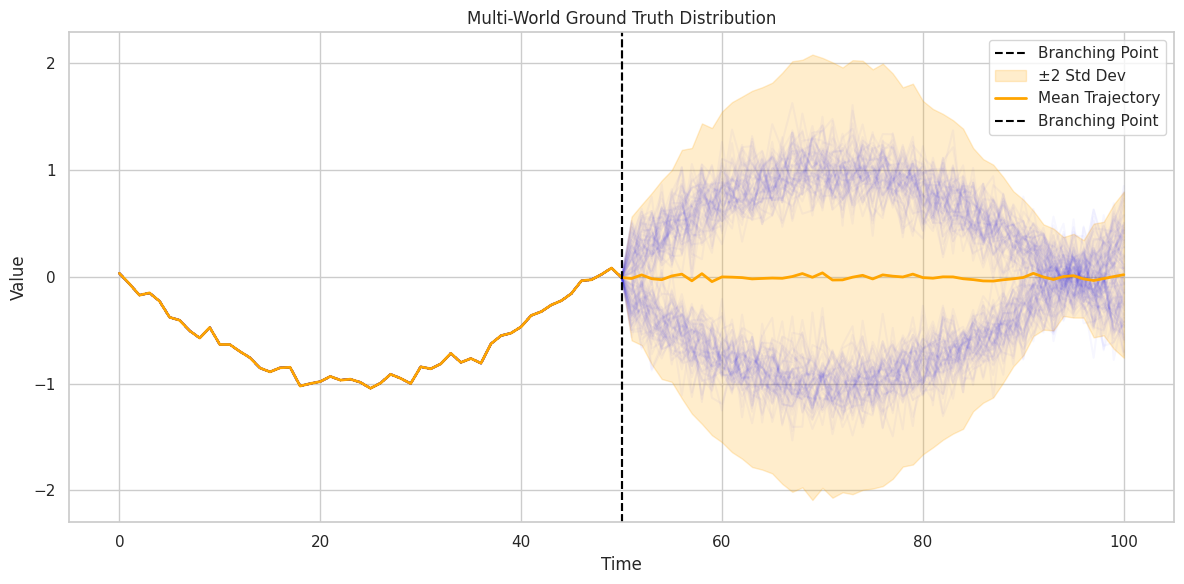

In [2]:
import torch
import os
import numpy as np
class DataGenerator:
    """Class for generating multi-world time series data."""
    
    def __init__(self, seq_len=100, prefix_len=50, noise_std=0.05, seed=42):
        """
        Initialize the data generator.
        
        Args:
            seq_len: Total sequence length
            prefix_len: Length of the common prefix before branching
            noise_std: Standard deviation of base noise
            seed: Random seed for reproducibility
        """
        self.seq_len = seq_len+2
        self.prefix_len = prefix_len+1
        self.noise_std = noise_std
        self.seed = seed
        
        # Set random seeds
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def generate_prefix(self, seed=None):
        """Generate a common prefix for all trajectories."""
        if seed is not None:
            np.random.seed(seed)
        
        x = np.arange(self.prefix_len)
        base_signal = np.sin(50/4 * x)
        base_signal[-1]=0
        noise = np.random.normal(0, self.noise_std, self.prefix_len)
        return base_signal + noise
    
    def generate_world_branch(self, world_fn, start_val, noise_scale=0.2, smooth_blend=10, seed=None):
        """
        Generate a smooth branch starting from start_val and following world_fn.
        
        Args:
            world_fn: Function defining the trajectory shape
            start_val: Starting value (last value of prefix)
            noise_scale: Scale of random noise
            smooth_blend: Number of points to smoothly blend from prefix
            seed: Random seed
        """
        if seed is not None:
            np.random.seed(seed)
            
        branch_len = self.seq_len - self.prefix_len
        x = np.arange(branch_len)
        target = world_fn(x)
        noise = np.random.normal(0, noise_scale, branch_len)
        target += noise

        # Smooth transition from start_val to world_fn using cosine blend
        transition = np.linspace(0, 1, smooth_blend)
        smooth_start = (1 - transition) * start_val + transition * target[:smooth_blend]
        return np.concatenate([smooth_start, target[smooth_blend:]])
    
    def sample_trajectories(self, n_samples=30, n_worlds=3):
        """
        Generate multiple trajectories across different worlds.
        
        Args:
            n_samples: Total number of samples to generate
            n_worlds: Number of distinct "world" patterns
            
        Returns:
            samples: [n_samples, seq_len] array of trajectories
            world_ids: [n_samples] array of world assignments
        """
        np.random.seed(self.seed)
        prefix = self.generate_prefix(seed=self.seed)
        branch_len = self.seq_len - self.prefix_len

        # Define distinct world behaviors
        world_functions = [
            lambda x: np.sin(50/4 * (x + self.prefix_len)),     # World 0: continues sine
            # lambda x: 0.5 * np.sin(0.2 * (x + self.prefix_len)),  # World 1: faster, smaller sine
            lambda x: -np.sin(50/4 * (x + self.prefix_len)),     # World 2: cosine
            lambda x: np.sin(0.1 * (x + self.prefix_len) + np.pi / 4),  # World 3: phase-shifted sine
            lambda x: np.zeros_like(x),                # World 4: flattens out
        ]
        assert n_worlds <= len(world_functions), "Too many worlds requested"

        # Distribute samples across worlds
        world_sizes = [n_samples // n_worlds] * n_worlds
        for i in range(n_samples % n_worlds):
            world_sizes[i] += 1

        print(world_sizes)

        samples, world_ids = [], []

        for world_id, count in enumerate(world_sizes):
            world_fn = world_functions[world_id]
            for j in range(count):
                branch = self.generate_world_branch(
                    world_fn,
                    start_val=prefix[-1],
                    smooth_blend=0,
                    seed=self.seed + j + world_id * 100
                )
                full_series = np.concatenate([prefix, branch])
                samples.append(full_series)
                world_ids.append(world_id)

        return np.stack(samples), np.array(world_ids)


from multi_world_experiment import Visualization
gen = DataGenerator(seq_len=100, prefix_len=50, noise_std=0.05, seed=23)
samples = gen.sample_trajectories(n_samples=100, n_worlds=2)[0]

Visualization.plot_multi_world_distribution(
        samples,
        world_ids=None,
        prefix_len=50,
        forecast_horizon=51,
        show_mean=True,
        show_std=True,
        title="Multi-World Ground Truth Distribution",
    )

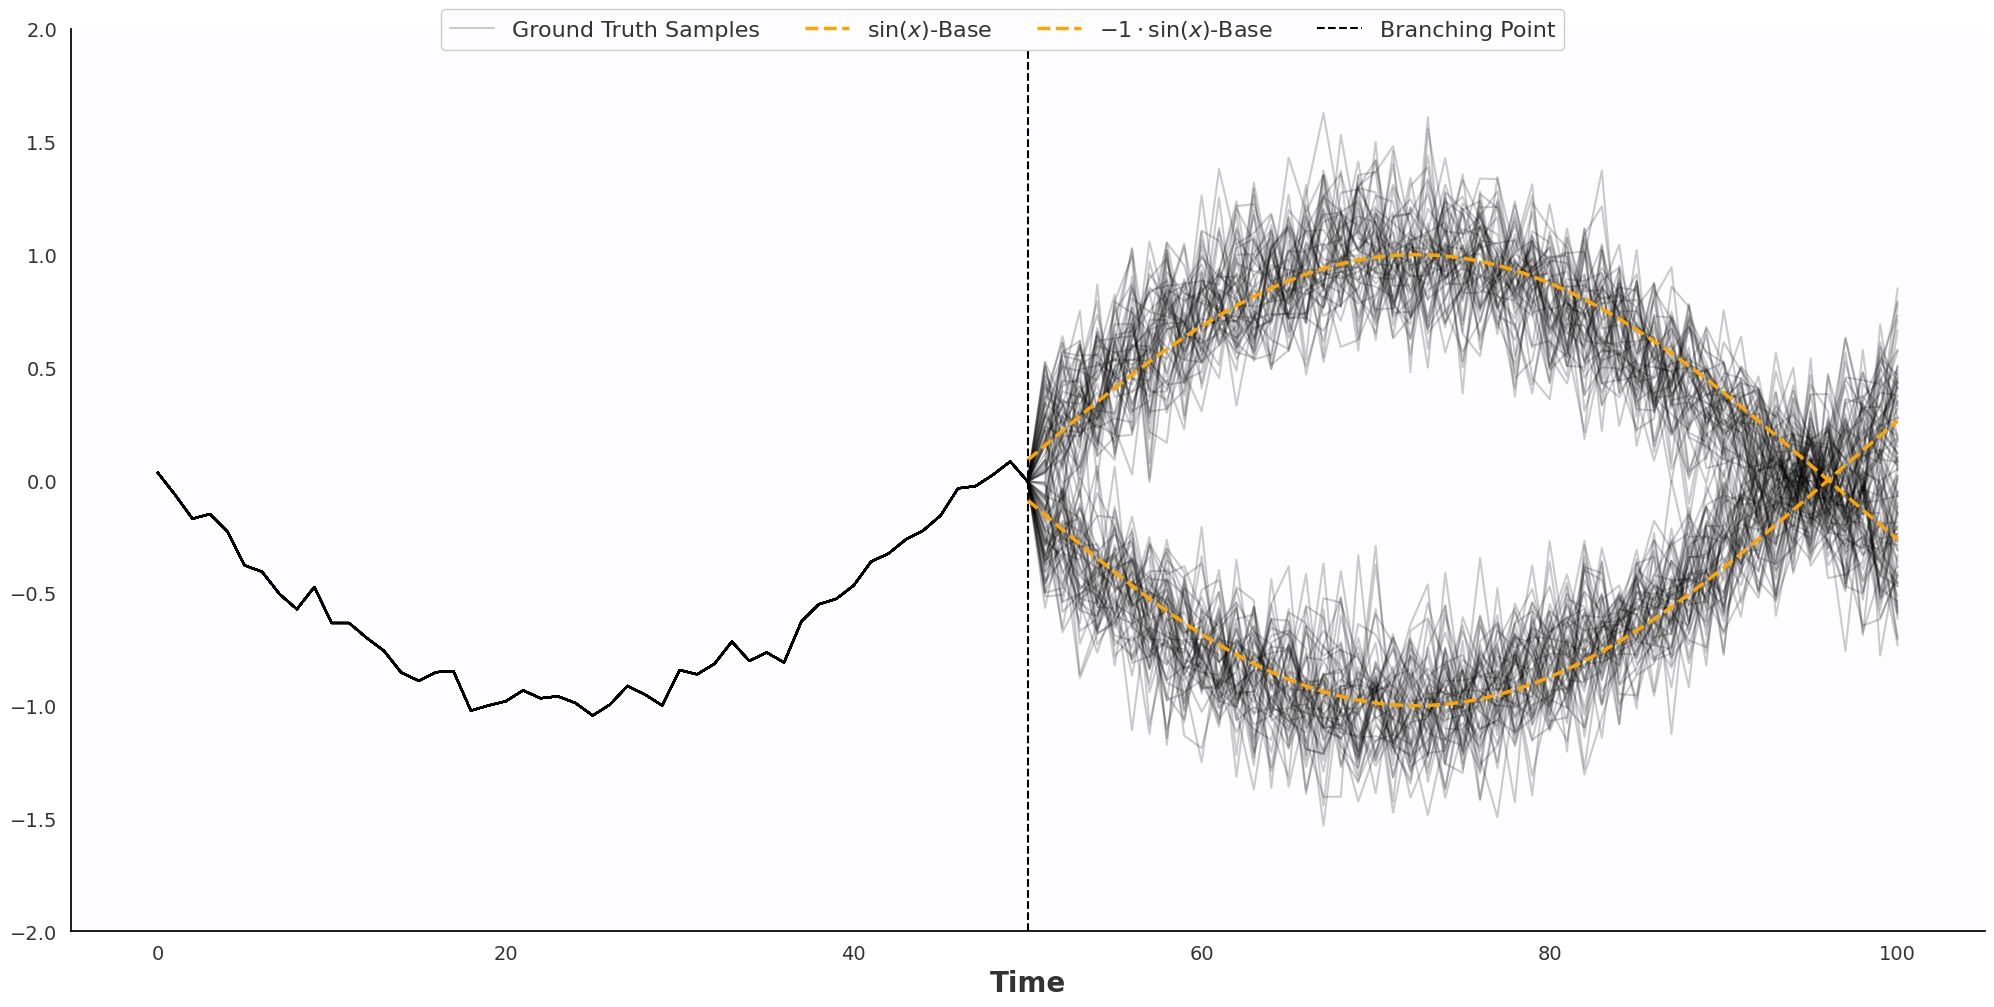

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
@staticmethod
def plot_multi_world_distribution(
    samples,
    world_ids=None,
    prefix_len=50,
    forecast_horizon=50,
    show_mean=True,
    show_std=True,
    title="Multi-World Ground Truth Distribution",
):
    """
    Visualizes sampled multi-world time series.
    
    Args:
        samples (np.ndarray): [n_samples, seq_len]
        world_ids: [n_samples] array indicating which world each sample belongs to
        prefix_len: number of observed time steps
        forecast_horizon: number of future steps to analyze
        show_mean (bool): plot mean of trajectories
        show_std (bool): show ±1 std deviation band
        title (str): plot title
    """
    n_samples, seq_len = samples.shape
    branching_point = prefix_len
    total_len = prefix_len + forecast_horizon
    x = np.arange(total_len)

    custom_text_color = "#333333"
    custom_bg = "#FDFDFF"
    
    custom_theme = {
        'axes.facecolor': custom_bg,
        'axes.edgecolor': 'black',
        'axes.grid': False,
        'grid.color': '#dcdcdc',
        'grid.linestyle': '-',
        'xtick.color': custom_text_color,
        'ytick.color': custom_text_color,
        'axes.labelcolor': custom_text_color,
        'text.color': custom_text_color
    }
    sns.set_theme(style='white')
    sns.set_style("white", rc=custom_theme)
    fig, ax = plt.subplots(figsize=(20, 10))
    if world_ids is not None:        
        # Get unique worlds and assign colors
        unique_worlds = np.unique(world_ids)
        n_worlds = len(unique_worlds)
        colors = plt.cm.tab10(np.linspace(0, 1, n_worlds))
        
        # Plot prefix samples (should be the same for all)
        for i in range(n_samples):
            ax.plot(x[:branching_point], samples[i, :branching_point], 
                    color="blue", alpha=0.1)
        
        # Plot each world with different colors
        for w, world_id in enumerate(unique_worlds):
            world_mask = world_ids == world_id
            world_samples = samples[world_mask]
            
            # Plot individual trajectories with world-specific color
            for i in range(world_samples.shape[0]):
                ax.plot(x[branching_point:total_len], 
                        world_samples[i, branching_point:total_len], 
                        color=colors[w], alpha=0.2)
            
            # World-specific mean and std
            if show_mean or show_std:
                world_mean = world_samples[:, branching_point:total_len].mean(axis=0)
                
                if show_mean:
                    ax.plot(x[branching_point:total_len], world_mean, 
                            color=colors[w], linewidth=2, 
                            label=f"World {world_id} Mean")
                
                if show_std:
                    world_std = world_samples[:, branching_point:total_len].std(axis=0)
                    ax.fill_between(
                        x[branching_point:total_len], 
                        world_mean - 2*world_std, 
                        world_mean + 2*world_std, 
                        color=colors[w], alpha=0.1
                    )
    else:    
        # Plot all sample trajectories
        for i in range(n_samples):
            if i==0:
                ax.plot(x, samples[i, :total_len], color="black", alpha=0.2, label='Ground Truth Samples')
            else:
                ax.plot(x, samples[i, :total_len], color="black", alpha=0.2)

        offset = 5
        world_1 = [np.sin(50/4 * (x + 51)) for x in np.arange(prefix_len-offset, prefix_len + forecast_horizon-offset)]
        world_2 = [-np.sin(50/4 * (x + 51)) for x in np.arange(prefix_len-offset, prefix_len + forecast_horizon-offset)]
        ax.plot(np.arange(prefix_len, prefix_len+ forecast_horizon), world_1, color='orange', linestyle='--', linewidth=2.5, label="$\sin(x)$-Base")
        ax.plot(np.arange(prefix_len, prefix_len+ forecast_horizon), world_2, color='orange', linestyle='--', linewidth=2.5, label="$-1\cdot\sin(x)$-Base")
    
        # Mean and std band
        if show_mean or show_std:
            mean = samples[:, :total_len].mean(axis=0)
            std = samples[:, :total_len].std(axis=0)
    
            if show_std:
                ax.fill_between(x, mean - 2*std, mean + 2*std, color="orange", alpha=0.2, label="±2 Std Dev")
    
            if show_mean:
                ax.plot(x, mean, color="orange", label="Mean Trajectory", linewidth=2)
        
    ax.axvline(branching_point, color="black", linestyle="--", label="Branching Point")
    ax.set_xlabel('Time', fontsize=20, fontweight='bold')
    # ax.set_ylabel('Value', fontsize=20, fontweight='bold')
    plt.tight_layout()
    sns.despine(left=False, bottom=False)
    # Create a single legend for the entire figure
    # Collect handles and labels from the last subplot (they should be consistent across all subplots)
    handles, labels = ax.get_legend_handles_labels()
    # handles = [handles[i] for i in [0, 1, 4, 7]]
    # labels = [labels[i] for i in [0]]+ ['Cooling', 'Idle', 'Heavy Load']
    # Place the legend outside the subplots
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), 
              bbox_to_anchor=(0.5, 0.95), fontsize=16, frameon=True, framealpha=1)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylim(-2, 2)
    plt.savefig("Base_example.pdf", format='pdf', dpi=600, bbox_inches='tight')
    plt.show()


plot_multi_world_distribution(
        samples,
        world_ids=None,
        prefix_len=50,
        forecast_horizon=51,
        show_mean=False,
        show_std=False,
        title="Multi-World Ground Truth Distribution",
    )

In [4]:
import os
os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/BasicTS')
from prob.prob_head import ProbabilisticHead
os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/experiments')
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
# train dms with m_lr_gaussian
class ProbabilisticDMSModel(nn.Module):
    """Direct Multi-Step (DMS) forecasting model."""
    def __init__(self, input_len, forecast_horizon, distribution_type='gaussian', prob_args={}):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_len, 64),
            nn.ReLU(),
            # nn.Linear(64, 2 * forecast_horizon)  # output mu and log_sigma
        )
        # Initialize the probabilistic head
        self.distribution_type = distribution_type
        self.prob_head = ProbabilisticHead(64, forecast_horizon, distribution_type, prob_args)
        self.forecast_horizon = forecast_horizon

    def forward(self, x):
        out = self.net(x)
        out = self.prob_head(out)
        # mu, log_sigma = out[..., :self.forecast_horizon], out[..., self.forecast_horizon:]
        # sigma = torch.exp(log_sigma.clamp(-5, 5))  # stability
        return out

    def get_distribution(self, head_output):
        """Get the distribution object from head output."""
        if self.distribution_type == "m_lr_gaussian":
            head_output = head_output.permute(0,2,1,3)
        return self.prob_head.__get_dist__(head_output)
    
    def sample(self, head_output, num_samples=1, random_state=None):
        """Sample from the model's distribution."""
        if self.distribution_type == "m_lr_gaussian":
             head_output = head_output.permute(0,2,1,3)
        return self.prob_head.sample(head_output, num_samples, random_state)
    
    def compute_loss(self, head_output, target):
        """Compute negative log-likelihood loss."""
        distributions = self.get_distribution(head_output)
        if self.distribution_type == "m_lr_gaussian":
            total_loss=0
            for distr in distributions:
                total_loss += -distr.log_prob(target).mean()
            return total_loss/len(distributions)
        else:
            # Handle univariate case
            return -distributions.log_prob(target).mean()
        
        
@staticmethod
def build_dms_dataset(samples, prefix_len, forecast_horizon):
    """
    Build training data for DMS model.
    
    Args:
        samples: [n_samples, seq_len] array of trajectories
        prefix_len: Length of input sequence
        forecast_horizon: Length of output sequence
        
    Returns:
        X_train: [n_samples, prefix_len] tensor
        Y_train: [n_samples, forecast_horizon] tensor
    """
    X = samples[:, :prefix_len]
    Y = samples[:, prefix_len:prefix_len + forecast_horizon]
    X_train = torch.tensor(X, dtype=torch.float32)
    Y_train = torch.tensor(Y, dtype=torch.float32)
    return X_train, Y_train

# Updated training function
def train_probabilistic_dms(model, X_train, Y_train, epochs=1000, lr=1e-3, verbose=True):
    """
    Train a probabilistic DMS forecast model.
    
    Args:
        model: ProbabilisticDMSModel instance
        X_train: [n_samples, input_len] tensor
        Y_train: [n_samples, forecast_horizon] tensor
        epochs: Number of training epochs
        lr: Learning rate
        verbose: Whether to print progress
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    pbar = tqdm(range(epochs), total=epochs, disable=not verbose)
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        head_output = model(X_train)
        
        # Compute loss
        loss = model.compute_loss(head_output, Y_train)
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        pbar.set_description(f"NLL: {loss.item():.4f}")
        
        if verbose and epoch % 200 == 0:
            print(f"Epoch {epoch}: NLL = {loss.item():.4f}")

In [5]:
def train_models(samples, input_len=50, forecast_horizon=51, epochs=500):
    # DMS
    from multi_world_experiment import ForecastModels
    import torch
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    g_dms = ProbabilisticDMSModel(
            input_len=input_len,
            forecast_horizon=forecast_horizon,
            distribution_type="gaussian"
        ).to(device)
    m_lr_dms = ProbabilisticDMSModel(
            input_len=input_len,
            forecast_horizon=forecast_horizon,
            distribution_type="m_lr_gaussian",
            prob_args={"rank": forecast_horizon}
        ).to(device)
    
    m_dms_2_model = ProbabilisticDMSModel(
            input_len=input_len,
            forecast_horizon=forecast_horizon,
            distribution_type="m_lr_gaussian",
            prob_args={"rank": int(forecast_horizon/2)}
        ).to(device)
    X_train, Y_train = build_dms_dataset(samples, input_len, forecast_horizon)
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    # training
    train_probabilistic_dms(g_dms, X_train, Y_train, epochs=epochs, lr=1e-3, verbose=True)
    train_probabilistic_dms(m_lr_dms, X_train, Y_train, epochs=epochs, lr=1e-3, verbose=True)
    train_probabilistic_dms(m_dms_2_model, X_train, Y_train, epochs=epochs, lr=1e-3, verbose=True)
    # IMS
    model_ims = ForecastModels.IMSLSTM(hidden_size=64).to(device)
    ForecastModels.train_ims_with_teacher_forcing(
        model_ims, samples, 50, 51,
        epochs=epochs, lr=1e-3, batch_size=64
    )
    return g_dms, m_lr_dms, m_dms_2_model, model_ims
g_dms, m_lr_dms, m_dms_2_model, model_ims = train_models(samples, input_len=50, forecast_horizon=51, epochs=400)

NLL: 0.7901:  12%|█▏        | 49/400 [00:00<00:01, 214.78it/s]

Epoch 0: NLL = 1.1383


NLL: 0.7872:  75%|███████▌  | 300/400 [00:00<00:00, 463.26it/s]

Epoch 200: NLL = 0.7807


NLL: 33.9655:  10%|█         | 42/400 [00:00<00:01, 213.06it/s]

Epoch 0: NLL = 73.7801


NLL: -14.9778:  60%|██████    | 241/400 [00:01<00:00, 242.09it/s]

Epoch 200: NLL = -14.7058


NLL: 30.3162:   6%|▋         | 25/400 [00:00<00:01, 245.98it/s]

Epoch 0: NLL = 69.5139


NLL: -13.2561:  62%|██████▎   | 250/400 [00:01<00:00, 245.63it/s]

Epoch 200: NLL = -13.4456


NLL: -14.5936: 100%|██████████| 400/400 [00:01<00:00, 245.06it/s]


using device cuda:0
Preparing training data...
(100, 102)


100%|██████████| 100/100 [00:00<00:00, 687590.82it/s]
/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/experiments/multi_world_experiment.py:334: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)  # [n_samples, input_len, 1]


Training with 100 samples in batches of 64


  0%|          | 1/400 [00:00<01:11,  5.60it/s]

Epoch 0 | Avg NLL: 1.2139


 20%|██        | 82/400 [00:10<00:40,  7.81it/s]

Epoch 80 | Avg NLL: -0.0789


 40%|████      | 162/400 [00:20<00:30,  7.79it/s]

Epoch 160 | Avg NLL: -0.1355


 60%|██████    | 242/400 [00:31<00:20,  7.82it/s]

Epoch 240 | Avg NLL: -0.1473


 80%|████████  | 322/400 [00:41<00:09,  7.82it/s]

Epoch 320 | Avg NLL: -0.1599


100%|██████████| 400/400 [00:51<00:00,  7.79it/s]


/scratch/slurm_tmpdir/job_614263/ipykernel_3429534/2712347236.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prefix_tensor = torch.tensor(prefix, dtype=torch.float32).unsqueeze(-1).to(device)


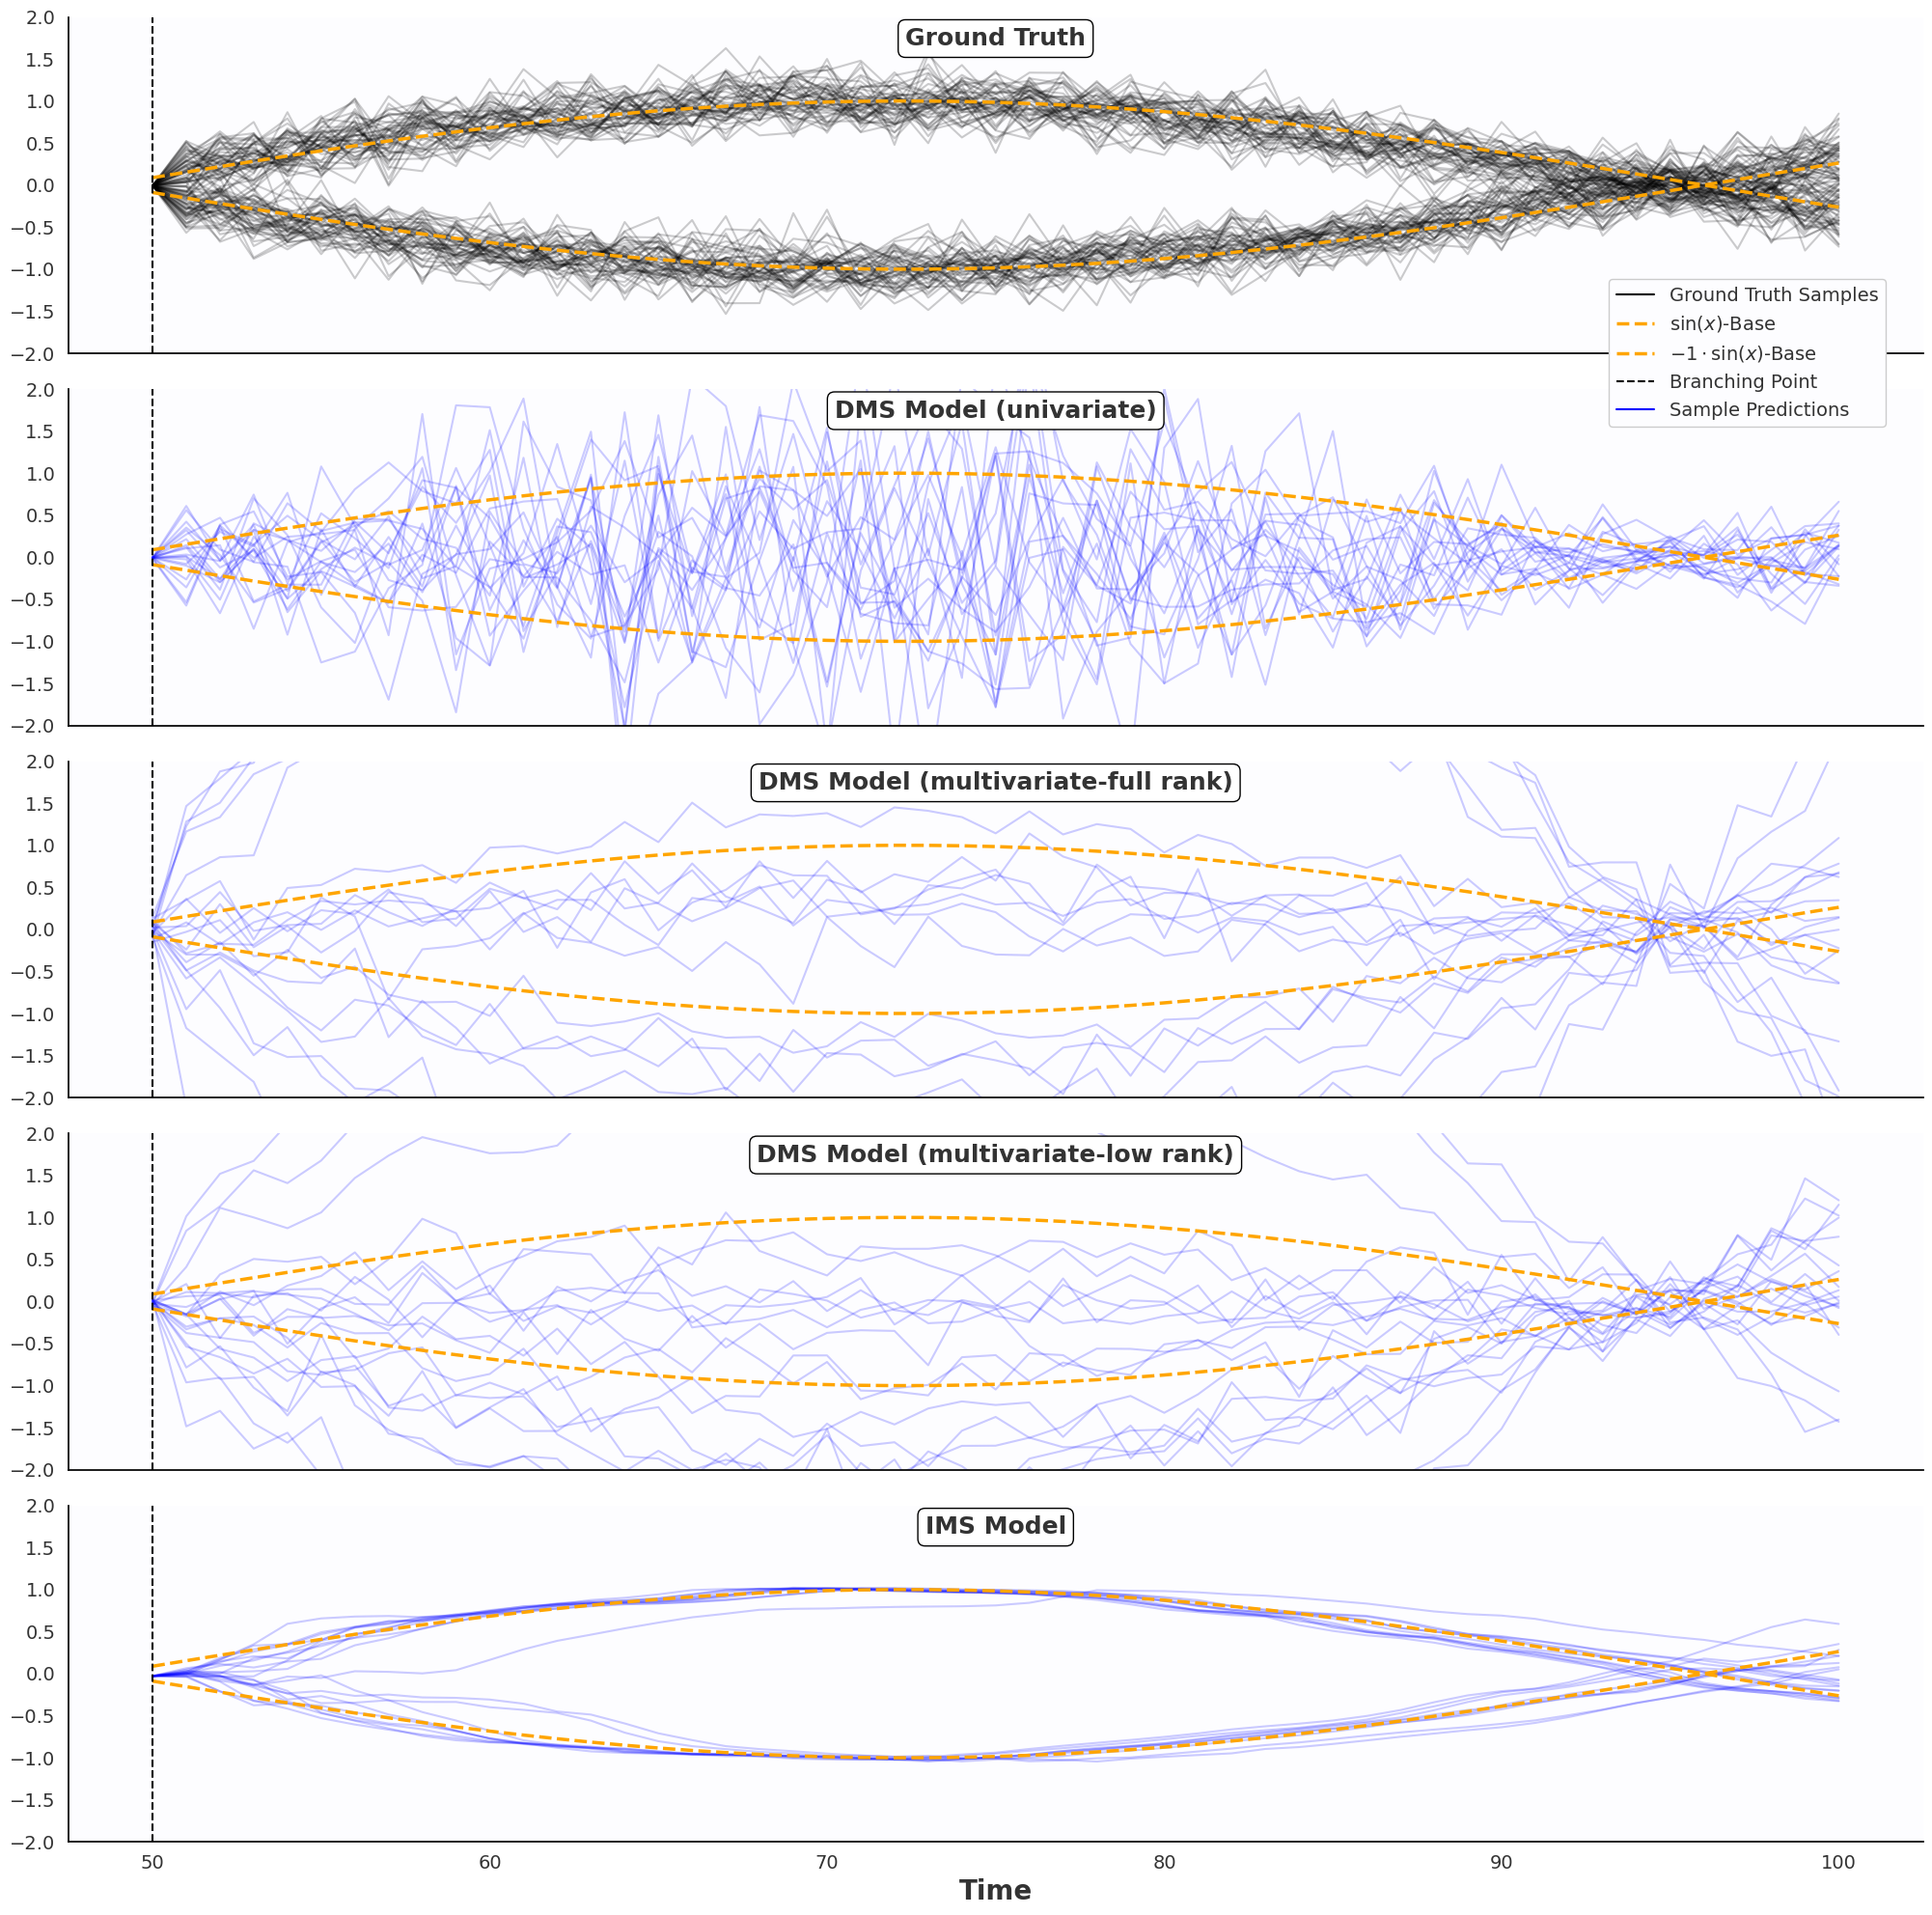

In [6]:
def get_samples(X_train, dms_model, m_dms_model, m_dms_2_model, ims_model, num_samples=50, random_state=42):
    # dms samples
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    prefix= X_train[:1, :].to(device)
    with torch.no_grad():
        dms_model.eval()
        head_output = dms_model(prefix)
        dms_samples = dms_model.sample(head_output, num_samples=num_samples, random_state=random_state)
        dms_samples = dms_samples.squeeze()

    with torch.no_grad():
        m_dms_model.eval()
        head_output = m_dms_model(prefix)
        m_dms_samples = m_dms_model.sample(head_output, num_samples=num_samples, random_state=random_state)
        m_dms_samples = m_dms_samples.squeeze()

    with torch.no_grad():
        m_dms_2_model.eval()
        head_output = m_dms_2_model(prefix)
        m_dms_2_samples = m_dms_2_model.sample(head_output, num_samples=num_samples, random_state=random_state)
        m_dms_2_samples = m_dms_2_samples.squeeze()
    
    
    with torch.no_grad():
        model_ims.eval()
        prefix_tensor = torch.tensor(prefix, dtype=torch.float32).unsqueeze(-1).to(device)
        ims_samples, sigmas_ims = model_ims.forecast(prefix_tensor, steps=51, use_mean=False, num_samples=num_samples)
        ims_samples = ims_samples.squeeze()

    return dms_samples, m_dms_samples, m_dms_2_samples, ims_samples
   
    


def plot_samples(X_train, Y_train, dms_samples, m_dms_samples, m_dms_2_samples, ims_samples):
    custom_text_color = "#333333"
    custom_bg = "#FDFDFF"
    
    custom_theme = {
        'axes.facecolor': custom_bg,
        'axes.edgecolor': 'black',
        'axes.grid': False,
        'grid.color': '#dcdcdc',
        'grid.linestyle': '-',
        'xtick.color': custom_text_color,
        'ytick.color': custom_text_color,
        'axes.labelcolor': custom_text_color,
        'text.color': custom_text_color
    }
    sns.set_theme(style='white')
    sns.set_style("white", rc=custom_theme)
    fig, axs = plt.subplots(nrows=5, figsize=(20, 20), sharey=True, sharex=True)

    # ground truth trajectory
    # lambda x: np.sin(50/4 * (x + self.prefix_len))     # World 0: continues sine
    # lambda x: -np.sin(50/4 * (x + self.prefix_len))    # World 2: cosine
    prefix = X_train[:1, :]
    offset = 5
    world_1 = [np.sin(50/4 * (x + 51)) for x in np.arange(prefix.shape[1]-offset, prefix.shape[1] + Y_train.shape[1]-offset)]
    world_2 = [-np.sin(50/4 * (x + 51)) for x in np.arange(prefix.shape[1]-offset, prefix.shape[1] + Y_train.shape[1]-offset)]

    
    # ground truth samples
    for s in range(Y_train.shape[0]):
        if s ==0:
            axs[0].plot(np.arange(prefix.shape[1], prefix.shape[1]+ Y_train.shape[1]), Y_train[s, :], color='black', alpha=0.2, label='Ground Truth Samples')
        else:
            axs[0].plot(np.arange(prefix.shape[1], prefix.shape[1]+ Y_train.shape[1]), Y_train[s, :], color='black', alpha=0.2)
    axs[0].plot(np.arange(prefix.shape[1], prefix.shape[1]+ Y_train.shape[1]), world_1, color='orange', linestyle='--', linewidth=2.5, label="$\sin(x)$-Base")
    axs[0].plot(np.arange(prefix.shape[1], prefix.shape[1]+ Y_train.shape[1]), world_2, color='orange', linestyle='--', linewidth=2.5, label="$-1\cdot\sin(x)$-Base")

    # dms samples
    # axs[1].plot(np.arange(prefix.shape[1]), prefix[0, :])
    for s in range(dms_samples.shape[0]):
        if s ==0:
            axs[1].plot(np.arange(prefix.shape[1], prefix.shape[1]+ dms_samples.shape[1]), dms_samples[s, :], color='blue', alpha=0.2, label='Sample Predictions')
        else:
            axs[1].plot(np.arange(prefix.shape[1], prefix.shape[1]+ dms_samples.shape[1]), dms_samples[s, :], color='blue', alpha=0.2)
    axs[1].plot(np.arange(prefix.shape[1], prefix.shape[1]+ dms_samples.shape[1]), world_1, color='orange', linestyle='--', linewidth=2.5)
    axs[1].plot(np.arange(prefix.shape[1], prefix.shape[1]+ dms_samples.shape[1]), world_2, color='orange', linestyle='--', linewidth=2.5)
    
        
    # dms multivariate samples
    # axs[2].plot(np.arange(prefix.shape[1]), prefix[0, :])
    for s in range(m_dms_samples.shape[0]):
        axs[2].plot(np.arange(prefix.shape[1], prefix.shape[1]+ m_dms_samples.shape[1]), m_dms_samples[s, :], color='blue', alpha=0.2)
    axs[2].plot(np.arange(prefix.shape[1], prefix.shape[1]+ m_dms_samples.shape[1]), world_1, color='orange', linestyle='--', linewidth=2.5)
    axs[2].plot(np.arange(prefix.shape[1], prefix.shape[1]+ m_dms_samples.shape[1]), world_2, color='orange', linestyle='--', linewidth=2.5)
    # axs[2].
    for s in range(m_dms_2_samples.shape[0]):
        axs[3].plot(np.arange(prefix.shape[1], prefix.shape[1]+ m_dms_2_samples.shape[1]), m_dms_2_samples[s, :], color='blue', alpha=0.2)
    axs[3].plot(np.arange(prefix.shape[1], prefix.shape[1]+ m_dms_2_samples.shape[1]), world_1, color='orange', linestyle='--', linewidth=2.5)
    axs[3].plot(np.arange(prefix.shape[1], prefix.shape[1]+ m_dms_2_samples.shape[1]), world_2, color='orange', linestyle='--', linewidth=2.5)
    # axs[2].
    
    # ims samples
    for s in range(ims_samples.shape[0]):
        axs[4].plot(np.arange(prefix.shape[1], prefix.shape[1]+ ims_samples.shape[1]), ims_samples[s, :], color='blue', alpha=0.2)
    axs[4].plot(np.arange(prefix.shape[1], prefix.shape[1]+ ims_samples.shape[1]), world_1, color='orange', linestyle='--', linewidth=2.5)
    axs[4].plot(np.arange(prefix.shape[1], prefix.shape[1]+ ims_samples.shape[1]), world_2, color='orange', linestyle='--', linewidth=2.5)
    
    for ax in axs:
        ax.axvline(prefix.shape[1], color="black", linestyle="--", label="Branching Point")
        ax.set_ylim(-2, 2) 
        ax.tick_params(axis='both', labelsize=14)
        # ax.set_ylabel('Value', fontsize=20, fontweight='bold')
    axs[-1].set_xlabel('Time', fontsize=20, fontweight='bold')
    labels = ['Ground Truth', 'DMS Model (univariate)', 'DMS Model (multivariate-full rank)', 'DMS Model (multivariate-low rank)', 'IMS Model']
    for i, ax in enumerate(axs):
        ax.text(
            0.5, 0.97, labels[i],
            transform=ax.transAxes,
            fontsize=18,
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment = 'center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black')
        )
    plt.tight_layout()
    sns.despine(left=False, bottom=False)
    # Create a single legend for the entire figure
    # Collect handles and labels from the last subplot (they should be consistent across all subplots)
    # Collect all handles and labels from all subplots
    all_handles = []
    all_labels = []
    for ax in axs:
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)
    
    # Remove duplicates while preserving order
    from collections import OrderedDict
    from matplotlib.lines import Line2D
    unique = list(OrderedDict.fromkeys(zip(all_handles, all_labels)))
    handles, labels = zip(*unique)
    
    # Create proxy handles with alpha=1 for the legend
    legend_handles = []
    for h in handles[:5]:
        if isinstance(h, Line2D):
            legend_handles.append(Line2D([], [], color=h.get_color(), linestyle=h.get_linestyle(), linewidth=h.get_linewidth(), alpha=1))
        else:
            legend_handles.append(h)
    # handles_1, labels_1 = axs[1].get_legend_handles_labels()
    # handles = [handles[:], handles_1[:]]
    # handles = [handles[i] for i in [0, 1, 4, 7]]
    # labels = [labels[i] for i in [0]]+ ['Cooling', 'Idle', 'Heavy Load']
    # Place the legend outside the subplots
    fig.legend(legend_handles, labels[:5], loc='lower center', ncol=1, #len(labels), 
              bbox_to_anchor=(0.9, 0.77), fontsize=14, frameon=True, framealpha=1)

X_train, Y_train = build_dms_dataset(samples, 50, 51)
dms_samples, m_dms_samples, m_dms_2_samples, ims_samples = get_samples(X_train, g_dms, m_lr_dms, m_dms_2_model, model_ims, num_samples=20, random_state=42)
X_train, Y_train, dms_samples, m_dms_samples, m_dms_2_samples, ims_samples = X_train.cpu(), Y_train.cpu(), dms_samples.cpu(), m_dms_samples.cpu(), m_dms_2_samples.cpu(), ims_samples.cpu()
plot_samples(X_train, Y_train, dms_samples, m_dms_samples, m_dms_2_samples, ims_samples)
plt.savefig("Synthetic_plots.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

/scratch/slurm_tmpdir/job_614263/ipykernel_3429534/2712347236.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prefix_tensor = torch.tensor(prefix, dtype=torch.float32).unsqueeze(-1).to(device)


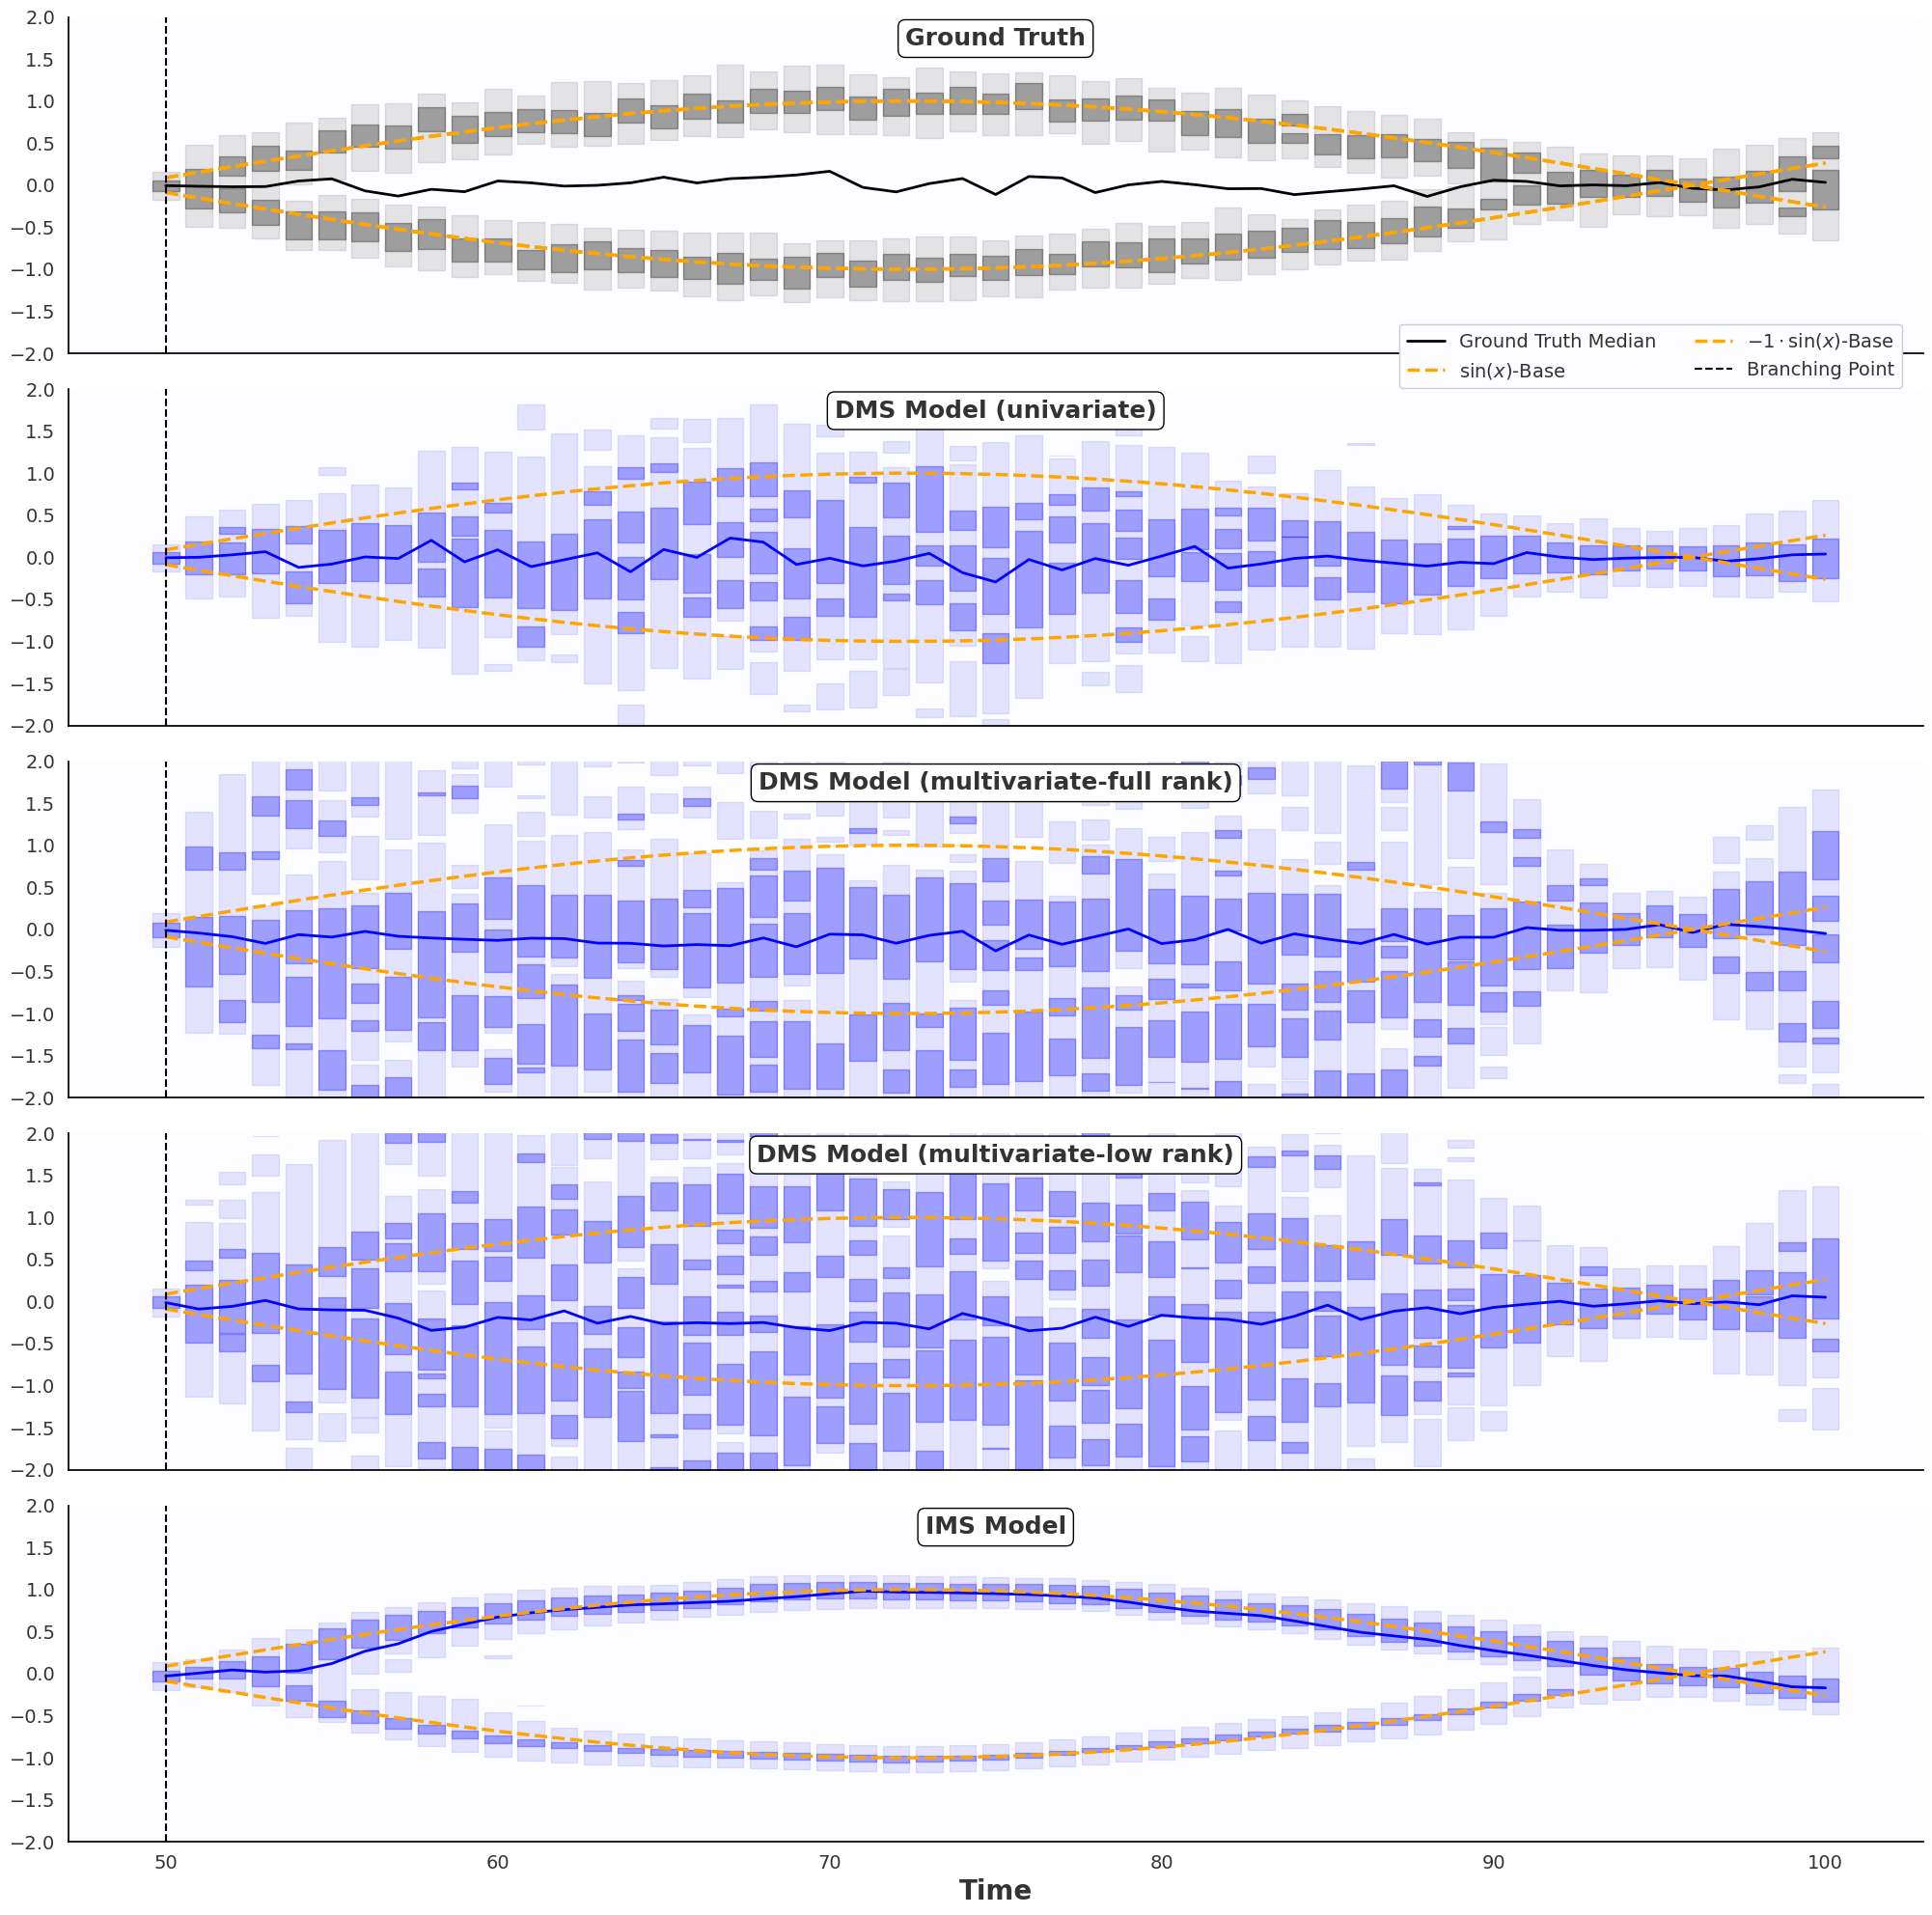

In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import label
import numpy as np

from sklearn.neighbors import KernelDensity

def get_kde_hdr_intervals(x, level=0.5, bandwidth=0.1, grid_size=1000):
    """
    Estimate HDR intervals using Kernel Density Estimation.
    """
    x = x.flatten()
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x[:, None])
    
    x_grid = np.linspace(np.min(x) - 0.5, np.max(x) + 0.5, grid_size)
    log_density = kde.score_samples(x_grid[:, None])
    density = np.exp(log_density)
    
    idx_sorted = np.argsort(-density)
    cumulative = np.cumsum(density[idx_sorted])
    cumulative /= cumulative[-1]

    threshold_idx = idx_sorted[cumulative <= level]
    hdr_mask = np.zeros_like(density, dtype=bool)
    hdr_mask[threshold_idx] = True
    
    labeled, num_features = label(hdr_mask)
    intervals = []
    for i in range(1, num_features + 1):
        region_idx = np.where(labeled == i)[0]
        if len(region_idx) > 0:
            low = x_grid[region_idx[0]]
            high = x_grid[region_idx[-1]]
            intervals.append((low, high))
    return intervals

def plot_sample_intervals(X_train, Y_train, dms_samples, m_dms_samples, m_dms_2_samples, ims_samples):
    custom_text_color = "#333333"
    custom_bg = "#FDFDFF"
    custom_theme = {
        'axes.facecolor': custom_bg,
        'axes.edgecolor': 'black',
        'axes.grid': False,
        'grid.color': '#dcdcdc',
        'xtick.color': custom_text_color,
        'ytick.color': custom_text_color,
        'axes.labelcolor': custom_text_color,
        'text.color': custom_text_color
    }

    sns.set_theme(style='white')
    sns.set_style("white", rc=custom_theme)
    fig, axs = plt.subplots(nrows=5, figsize=(20, 20), sharey=True, sharex=True)

    prefix = X_train[:1, :]
    offset = 5
    t = np.arange(prefix.shape[1], prefix.shape[1] + Y_train.shape[1])
    world_1 = [np.sin(50/4 * (x + 51)) for x in np.arange(prefix.shape[1]-offset, prefix.shape[1] + Y_train.shape[1]-offset)]
    world_2 = [-np.sin(50/4 * (x + 51)) for x in np.arange(prefix.shape[1]-offset, prefix.shape[1] + Y_train.shape[1]-offset)]

    def plot_ci(ax, samples, color, label=None):
        median = np.median(samples, axis=0)
        p25 = np.percentile(samples, 25, axis=0)
        p75 = np.percentile(samples, 75, axis=0)
        p5 = np.percentile(samples, 5, axis=0)
        p95 = np.percentile(samples, 95, axis=0)

        ax.plot(t, median, color=color, label=label, linewidth=2)
        ax.fill_between(t, p25, p75, color=color, alpha=0.3, label="50% CI" if label else None)
        ax.fill_between(t, p5, p95, color=color, alpha=0.1, label="90% CI" if label else None)
    
    def get_hdr_intervals(x, density, level=0.5):
        n_samples = len(x)
        n_hdr = int(n_samples * level)
        top_idx = np.argsort(density)[-n_hdr:]
        hdr_points = np.zeros(n_samples, dtype=bool)
        hdr_points[top_idx] = True
    
        # Sort by x for connected component analysis
        sorted_idx = np.argsort(x.flatten())
        mask_sorted = hdr_points[sorted_idx]
        
        # Label contiguous high-density regions
        labeled, num_features = label(mask_sorted)
        intervals = []
        for i in range(1, num_features + 1):
            region_idx = sorted_idx[labeled == i]
            region_vals = x[region_idx]
            intervals.append((np.min(region_vals), np.max(region_vals)))
        return intervals
    
    def plot_ci_knn(ax, samples, color, label=None, alpha_50=0.3, alpha_90=0.1, k=10):
        n_samples, n_timesteps = samples.shape
        # t = np.arange(n_timesteps)
        median = np.median(samples, axis=0)
    
        for t_idx in range(n_timesteps):
            x = samples[:, t_idx].reshape(-1, 1)
            nbrs = NearestNeighbors(n_neighbors=k).fit(x)
            distances, _ = nbrs.kneighbors(x)
            density = -np.mean(distances, axis=1)  # Higher density = less distance
    
            # Plot 50% HDR
            intervals_50 = get_hdr_intervals(x, density, level=0.5)
            for low, high in intervals_50:
                ax.fill_between([t[t_idx]-0.4, t[t_idx]+0.4], [low, low], [high, high],
                                color=color, alpha=alpha_50)
    
            # Plot 90% HDR
            intervals_90 = get_hdr_intervals(x, density, level=0.9)
            for low, high in intervals_90:
                ax.fill_between([t[t_idx]-0.4, t[t_idx]+0.4], [low, low], [high, high],
                                color=color, alpha=alpha_90)
    
        ax.plot(t, median, color=color, label=label, linewidth=2)
    def plot_ci_kde(ax, samples, color, label=None, alpha_50=0.3, alpha_90=0.1, bandwidth=0.1):
        n_samples, n_timesteps = samples.shape
        median = np.median(samples, axis=0)
        
        for t_idx in range(n_timesteps):
            x = samples[:, t_idx]
            
            # Plot 50% HDR
            intervals_50 = get_kde_hdr_intervals(x, level=0.5, bandwidth=bandwidth)
            for low, high in intervals_50:
                ax.fill_between([t[t_idx]-0.4, t[t_idx]+0.4], [low, low], [high, high],
                                color=color, alpha=alpha_50)
            
            # Plot 90% HDR
            intervals_90 = get_kde_hdr_intervals(x, level=0.9, bandwidth=bandwidth)
            for low, high in intervals_90:
                ax.fill_between([t[t_idx]-0.4, t[t_idx]+0.4], [low, low], [high, high],
                                color=color, alpha=alpha_90)
        
        ax.plot(t, median, color=color, label=label, linewidth=2)



    # Ground Truth
    plot_ci_kde(axs[0], Y_train.numpy(), 'black', label='Ground Truth Median')
    # plot_ci(axs[0], Y_train.numpy(), 'black', label='Ground Truth Median')
    
    axs[0].plot(t, world_1, color='orange', linestyle='--', linewidth=2.5, label="$\sin(x)$-Base")
    axs[0].plot(t, world_2, color='orange', linestyle='--', linewidth=2.5, label="$-1\cdot\sin(x)$-Base")

    # DMS Models
    plot_ci_kde(axs[1], dms_samples.numpy(), 'blue')
    plot_ci_kde(axs[2], m_dms_samples.numpy(), 'blue')
    plot_ci_kde(axs[3], m_dms_2_samples.numpy(), 'blue')
    plot_ci_kde(axs[4], ims_samples.numpy(), 'blue')
    # plot_ci(axs[1], dms_samples.numpy(), 'blue')
    # plot_ci(axs[2], m_dms_samples.numpy(), 'blue')
    # plot_ci(axs[3], m_dms_2_samples.numpy(), 'blue')
    # plot_ci(axs[4], ims_samples.numpy(), 'blue')

    
    for i, ax in enumerate(axs):
        ax.plot(t, world_1, color='orange', linestyle='--', linewidth=2.5)
        ax.plot(t, world_2, color='orange', linestyle='--', linewidth=2.5) 
        ax.axvline(prefix.shape[1], color="black", linestyle="--", label="Branching Point")
        ax.set_ylim(-2, 2)
        ax.tick_params(axis='both', labelsize=14)

    axs[-1].set_xlabel('Time', fontsize=20, fontweight='bold')
    labels = ['Ground Truth', 'DMS Model (univariate)', 'DMS Model (multivariate-full rank)', 'DMS Model (multivariate-low rank)', 'IMS Model']
    for i, ax in enumerate(axs):
        ax.text(
            0.5, 0.97, labels[i],
            transform=ax.transAxes,
            fontsize=18,
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment = 'center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black')
        )

    plt.tight_layout()
    sns.despine(left=False, bottom=False)

    # Legend (only first subplot)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.85, 0.79), fontsize=14, frameon=True, framealpha=1)
dms_samples, m_dms_samples, m_dms_2_samples, ims_samples = get_samples(X_train, g_dms, m_lr_dms, m_dms_2_model, model_ims, num_samples=100, random_state=42)
X_train, Y_train, dms_samples, m_dms_samples, m_dms_2_samples, ims_samples = X_train.cpu(), Y_train.cpu(), dms_samples.cpu(), m_dms_samples.cpu(), m_dms_2_samples.cpu(), ims_samples.cpu()
plot_sample_intervals(X_train, Y_train, dms_samples, m_dms_samples, m_dms_2_samples, ims_samples)
plt.savefig("Synthetic_plots_intervals_knn.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

In [8]:
# evaluate the models
import torch
def vs_ensemble_torch(obs, fct, p=1.0):
    """
    Compute Variogram Score using PyTorch on GPU.
    obs: shape (..., D)
    fct: shape (..., M, D)
    """
    M = fct.shape[-2]

    # Compute ensemble variogram component
    fct_diff = fct.unsqueeze(-2) - fct.unsqueeze(-1)  # (B, M, D, D)
    # print(fct_diff.shape)
    vfct = (fct_diff.abs() ** p).sum(dim=-3) / M  # (B, D, D)
    # print(vfct.shape)
    # Compute observed variogram component
    obs_diff = obs.unsqueeze(-2) - obs.unsqueeze(-1)  # (B, D, D)
    vobs = (obs_diff.abs() ** p)  # (B, D, D)
    # print(vobs.shape)
    # print(vfct.shape)
    vs = ((vfct - vobs) ** 2).sum(dim=(-2, -1))  # (B,)
    return vs

def es_ensemble_torch(obs: torch.Tensor, fct: torch.Tensor) -> torch.Tensor:
    """
    Compute the energy score using PyTorch.
    
    Parameters:
    - obs: Tensor of shape (B, D)
    - fct: Tensor of shape (B, M, D)

    Returns:
    - Tensor of shape (B,) with energy scores
    """
    M = fct.shape[-2]

    # E_1: mean norm between forecast samples and the observation
    err_norm = torch.norm(fct - obs.unsqueeze(-2), dim=-1)  # (B, M)
    E_1 = err_norm.sum(dim=-1) / M  # (B,)

    # E_2: mean pairwise distance between forecast samples
    spread = fct.unsqueeze(-3) - fct.unsqueeze(-2)  # (B, M, M, D)
    spread_norm = torch.norm(spread, dim=-1)  # (B, M, M)
    E_2 = spread_norm.sum(dim=(-2, -1)) / (M**2) # (B,)

    return E_1 - 0.5 * E_2  # (B,)

In [9]:
def coverage(y, forecast):
    return np.mean(forecast >= y)
    
def sharpness(lower, upper, y):
    return np.mean((upper - lower) / np.abs(y))

def quantile_score(y, forecast, alpha):
    """
    Quantile score for a given quantile level (alpha).
    Lower is better.
    """
    return np.mean(2 * ((y < forecast) - alpha) * (forecast - y))

def interval_score(y, lower, upper, alpha):
    """
    Interval score for central prediction intervals.
    Lower is better.
    """
    return np.mean((upper - lower) + 
                   (2 / alpha) * (lower - y) * (y < lower) + 
                   (2 / alpha) * (y - upper) * (y > upper))

def weighted_quantile_score(y, forecast_quantiles, quantile_levels):
    """
    Computes the weighted Quantile Score (wQS).
    y: array of shape (D,)
    forecast_quantiles: array of shape (len(quantile_levels), D)
    """
    D = y.shape[0]
    qs_sum = 0
    for i, alpha in enumerate(quantile_levels):
        qs = quantile_score(y, forecast_quantiles[i], alpha)
        qs_sum += qs
    wqs = qs_sum / np.sum(np.abs(y)) if np.sum(np.abs(y)) != 0 else np.nan
    return wqs / len(quantile_levels)


def weighted_interval_score(y, forecast_quantiles, interval_bounds):
    """
    Computes the Weighted Interval Score (WIS).
    y: array of shape (D,)
    forecast_quantiles: array of shape (len(quantile_levels), D)
    interval_bounds: dict like {0.5: (0.25, 0.75), ...}
    """
    median = forecast_quantiles[quantile_levels.index(0.5)]
    wis = 0.5 * np.mean(np.abs(y - median))  # w0 * |y - median|

    for alpha in interval_bounds:
        lower_idx = quantile_levels.index(interval_bounds[alpha][0])
        upper_idx = quantile_levels.index(interval_bounds[alpha][1])
        lower = forecast_quantiles[lower_idx]
        upper = forecast_quantiles[upper_idx]
        iscore = interval_score(y, lower, upper, alpha=1 - alpha)
        wis += (1 - alpha) * iscore / 2  # wk = alpha/2 = (1 - alpha)/2

    K = len(interval_bounds)
    return wis / (K + 0.5)



import scoringrules as sr
ground_truth = torch.tensor(samples[:, 51:])

device = 'cuda:0'
quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
interval_bounds = {0.5: (0.25, 0.75), 0.67: (0.165, 0.835), 0.95: (0.025, 0.975), 0.99: (0.005, 0.995)}
metrics = ['crps', 'vs_05', 'vs_1', 'vs_2', 'es', 'wqs', 'wis']
metrics = metrics + [f"{m}{quantile}" for quantile in quantile_levels for m in ['coverage_', 'qs_']]
metrics = metrics + [f"{m}{interval}" for interval in interval_bounds.keys() for m in ['sharpness_', 'is_']]
sample_list = [dms_samples, m_dms_samples, m_dms_2_samples, ims_samples]
results = {'DMS': {}, 'M_DMS':{}, 'M_DMS_2':{}, 'IMS':{}}
for i, s in enumerate(sample_list):
    key = list(results.keys())[i]
    for metric in metrics:
        results[key][metric] = [] 
    for g in range(ground_truth.shape[0]):
        target = ground_truth[g, :]
        prediction = s.permute(1, 0)
        results[key]['crps'].append(np.mean(sr.crps_ensemble(target.detach().cpu(), prediction.detach().cpu(), estimator='pwm')))
        prediction=s
        results[key]['vs_05'].append(torch.mean(vs_ensemble_torch(target.to(device), prediction.to(device), p=0.5)).cpu().numpy())
        # vs_1 = np.mean(sr.variogram_score(target.permute(0, 2, 1), samples.permute(0, 2, 3, 1), p=1.0, backend='numba'))
        results[key]['vs_1'].append(torch.mean(vs_ensemble_torch(target.to(device), prediction.to(device), p=1)).cpu().numpy())
        results[key]['vs_2'].append(torch.mean(vs_ensemble_torch(target.to(device), prediction.to(device), p=2)).cpu().numpy())
        results[key]['es'].append(torch.mean(es_ensemble_torch(target.to(device), prediction.to(device))).cpu().numpy())
        
        # now determine the quantiles of the forecasts and determine the quantile metrics
        quantiles = np.quantile(prediction, quantile_levels, axis=0)
        
        # evaluate interval metrics
        for interval in interval_bounds.keys():
            lower = torch.tensor(quantiles[quantile_levels.index(interval_bounds[interval][0])]).numpy()
            upper = torch.tensor(quantiles[quantile_levels.index(interval_bounds[interval][1])]).numpy()
            results[key][f'sharpness_{interval}'].append(sharpness(lower, upper, target.numpy()))
            results[key][f'is_{interval}'].append(interval_score(target.numpy(), lower, upper, alpha=1 - interval))

        for quantile in quantile_levels:
            forecast = quantiles[quantile_levels.index(quantile)]
            results[key][f'coverage_{quantile}'].append(coverage(target.numpy(), forecast))
            results[key][f'qs_{quantile}'].append(quantile_score(target.numpy(), forecast, alpha=quantile))

        # Compute WQS and WIS
        results[key]['wqs'].append(weighted_quantile_score(target.numpy(), quantiles, quantile_levels))
        results[key]['wis'].append(weighted_interval_score(target.numpy(), quantiles, interval_bounds))

        
    for metric in results[key].keys():
        results[key][metric] = round(np.mean(results[key][metric]), 4)
print(results)

{'DMS': {'crps': np.float64(0.3933), 'vs_05': np.float64(303.6543), 'vs_1': np.float64(705.9045), 'vs_2': np.float64(2472.775), 'es': np.float64(3.6286), 'wqs': np.float64(0.0079), 'wis': np.float64(0.252), 'coverage_0.005': np.float64(0.0137), 'qs_0.005': np.float64(0.0204), 'coverage_0.025': np.float64(0.0276), 'qs_0.025': np.float64(0.0671), 'coverage_0.165': np.float64(0.2531), 'qs_0.165': np.float64(0.2981), 'coverage_0.25': np.float64(0.3927), 'qs_0.25': np.float64(0.442), 'coverage_0.5': np.float64(0.4978), 'qs_0.5': np.float64(0.6222), 'coverage_0.75': np.float64(0.6047), 'qs_0.75': np.float64(0.4338), 'coverage_0.835': np.float64(0.7398), 'qs_0.835': np.float64(0.2976), 'coverage_0.975': np.float64(0.98), 'qs_0.975': np.float64(0.0668), 'coverage_0.995': np.float64(0.9861), 'qs_0.995': np.float64(0.0204), 'sharpness_0.5': np.float64(4.1376), 'is_0.5': np.float64(1.7516), 'sharpness_0.67': np.float64(6.0576), 'is_0.67': np.float64(1.8052), 'sharpness_0.95': np.float64(11.3332),

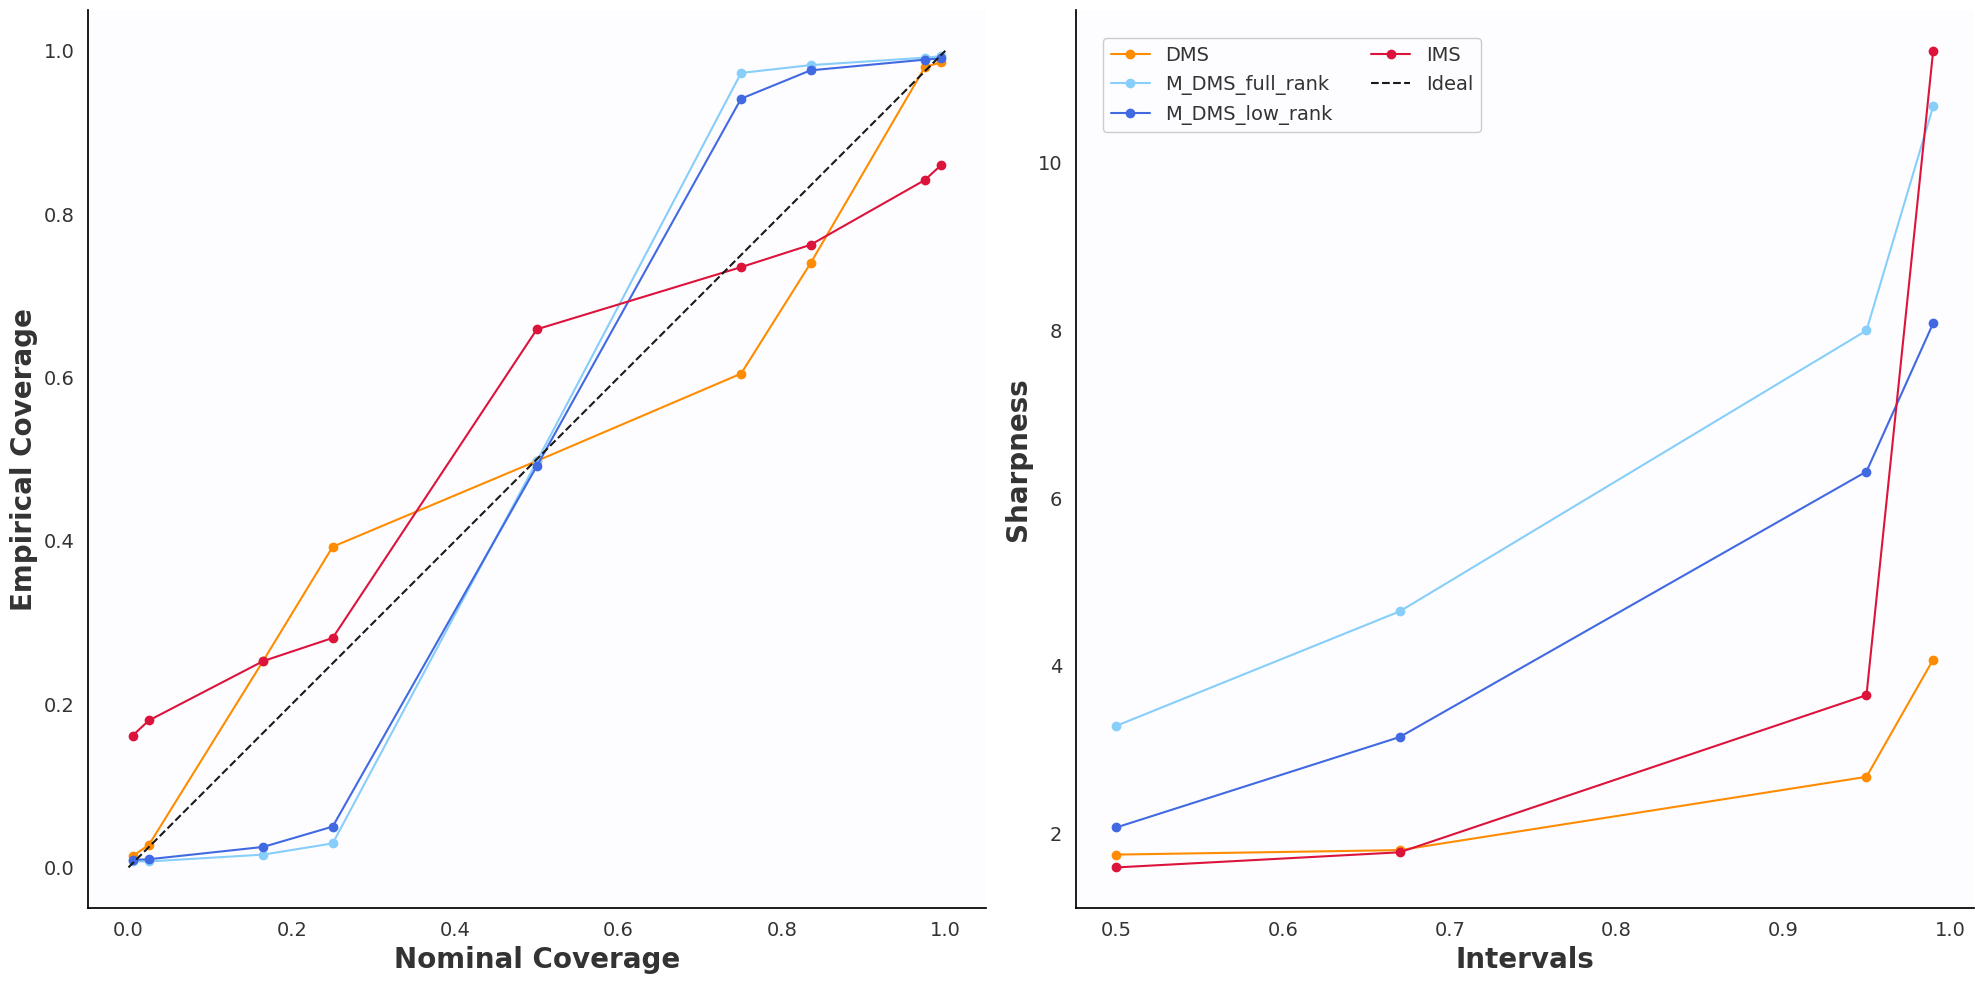

In [10]:
import matplotlib.pyplot as plt

# Extract nominal quantiles from the keys
quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Nominal coverages = the quantile levels themselves
nominal_coverage = quantile_levels

# Extract empirical coverage from results
custom_text_color = "#333333"
custom_bg = "#FDFDFF"
custom_theme = {
    'axes.facecolor': custom_bg,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#dcdcdc',
    'xtick.color': custom_text_color,
    'ytick.color': custom_text_color,
    'axes.labelcolor': custom_text_color,
    'text.color': custom_text_color
}

sns.set_theme(style='white')
sns.set_style("white", rc=custom_theme)
fig, axs = plt.subplots(ncols=2, figsize=(20, 10),)# sharey=True, sharex=True
colors = {
    'DMS': "#FF8C00",     # DarkOrange – warm, vibrant
    'M_DMS': "#87CEFA",   # LightSkyBlue – cool contrast to DMS
    'M_DMS_2': "#4169E1", # RoyalBlue – deeper blue, works with LightSkyBlue
    'IMS': "#DC143C"      # Crimson – striking and stands apart from others
}
for model_name in ['DMS', 'M_DMS', 'M_DMS_2', 'IMS']:
    empirical_coverage = [results[model_name][f'coverage_{q}'] for q in quantile_levels]
    
    if model_name == 'M_DMS':
        axs[0].plot(nominal_coverage, empirical_coverage, marker='o', color=colors[model_name], label='M_DMS_full_rank')
    elif model_name == 'M_DMS_2':
        axs[0].plot(nominal_coverage, empirical_coverage, marker='o', color=colors[model_name], label='M_DMS_low_rank')
    else:
        axs[0].plot(nominal_coverage, empirical_coverage, marker='o', color=colors[model_name], label=model_name)
axs[0].plot([0, 1], [0, 1], 'k--', label='Ideal')  # diagonal line
axs[0].set_xlabel("Nominal Coverage", fontsize=20, fontweight='bold')
axs[0].set_ylabel("Empirical Coverage", fontsize=20, fontweight='bold')

for model_name in ['DMS', 'M_DMS', 'M_DMS_2', 'IMS']:
    _is = [results[model_name][f'is_{i}'] for i in interval_bounds.keys()]
    if model_name == 'M_DMS':
        axs[1].plot(list(interval_bounds.keys()), _is, marker='o', color=colors[model_name], label='M_DMS_full_rank')
    elif model_name == 'M_DMS_2':
        axs[1].plot(list(interval_bounds.keys()), _is, marker='o', color=colors[model_name], label='M_DMS_low_rank')
    else:
        axs[1].plot(list(interval_bounds.keys()), _is, marker='o', color=colors[model_name], label=model_name)
axs[1].set_xlabel("Intervals", fontsize=20, fontweight='bold')
axs[1].set_ylabel("Sharpness", fontsize=20, fontweight='bold')

for ax in axs:
    ax.tick_params(axis='both', labelsize=14)

# plt.title(f"Coverage QQ Plot: {model_name}")
plt.tight_layout()
sns.despine(left=False, bottom=False)
# Legend (only first subplot)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.65, 0.85), fontsize=14, frameon=True, framealpha=1)
plt.savefig("Coverage_and_sharpness.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
from scipy.stats import gaussian_kde
import numpy as np
from sklearn.neighbors import NearestNeighbors

def estimate_kl_divergence(samples_p, samples_q):
    """
    Estimate KL(P || Q) where samples_p are from P (ground truth),
    and samples_q are from Q (model predictions).
    Both should have shape (num_samples, dim).
    """
    kde_p = gaussian_kde(samples_p.T)
    kde_q = gaussian_kde(samples_q.T)
    
    eps = 1e-10  # numerical stability

    # Evaluate both densities at samples from P (ground truth)
    log_p = np.log(kde_p(samples_p.T) + eps)
    log_q = np.log(kde_q(samples_p.T) + eps)

    kl = np.mean(log_p - log_q)
    print(kl)
    return kl
    
def estimate_kl_divergence_kde_sklearn(samples_p, samples_q, bandwidth=0.1):
    """
    Estimate KL(P || Q) using KDE from sklearn.
    - samples_p: Ground truth samples (n_samples, dim)
    - samples_q: Model prediction samples (n_samples, dim)
    """
    kde_p = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(samples_p)
    kde_q = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(samples_q)

    log_p = kde_p.score_samples(samples_p)
    log_q = kde_q.score_samples(samples_p)

    kl = np.mean(log_p - log_q)
    return kl


def kl_divergence_knn(X, Y, k=5):
    """
    Estimate KL(P || Q) where:
    - X ~ P (ground truth samples) of shape (n_samples, dim)
    - Y ~ Q (prediction samples) of shape (n_samples, dim)
    """
    n, d = X.shape

    # Distance to k-th nearest neighbor in same distribution (P)
    nn_X = NearestNeighbors(n_neighbors=k + 1).fit(X)
    r = nn_X.kneighbors(X, return_distance=True)[0][:, -1]

    # Distance to k-th nearest neighbor in other distribution (Q)
    nn_Y = NearestNeighbors(n_neighbors=k).fit(Y)
    s = nn_Y.kneighbors(X, return_distance=True)[0][:, -1]

    eps = 1e-10  # Avoid log(0)
    return d * np.mean(np.log((s + eps) / (r + eps))) + np.log(Y.shape[0] / (X.shape[0] - 1))
sample_list = [dms_samples, m_dms_samples, m_dms_2_samples, ims_samples]
for s in sample_list:
    # kl = estimate_kl_divergence(ground_truth, s)
    print(f"sklearn KDE {estimate_kl_divergence_kde_sklearn(ground_truth, s, bandwidth=0.1)}")
    kl = kl_divergence_knn(ground_truth, s)
    print(f"KNN {kl}")


sklearn KDE 1275.6065464556827
KNN 60.17625322971027
sklearn KDE 210.6684938168145
KNN 21.32006643824594
sklearn KDE 187.70110024471512
KNN 11.770882641197337
sklearn KDE 101.46287526083
KNN -8.250848904160312


In [41]:
# Efficient KDE/KNN-based evaluation cell
import numpy as np
import torch
from sklearn.neighbors import KernelDensity, NearestNeighbors
from scipy.ndimage import label
import scoringrules as sr

def compute_densities(samples, method='kde', bandwidth=0.1, k=10, grid_size=1000):
    """
    Precompute densities for all timesteps using KDE or KNN.
    
    Returns:
    - densities: dict with timestep as key, (x_grid, density) as value for KDE
                 or (x_values, density) for KNN
    - method_params: dict with method parameters
    """
    if hasattr(samples, 'detach'):
        samples = samples.detach().cpu().numpy()
    
    n_samples, n_timesteps = samples.shape
    densities = {}
    
    if method == 'kde':
        for t_idx in range(n_timesteps):
            x = samples[:, t_idx].flatten()
            kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x[:, None])
            
            x_grid = np.linspace(np.min(x) - 0.5, np.max(x) + 0.5, grid_size)
            log_density = kde.score_samples(x_grid[:, None])
            density = np.exp(log_density)
            
            densities[t_idx] = (x_grid, density)
            
        method_params = {'bandwidth': bandwidth, 'grid_size': grid_size}
        
    elif method == 'knn':
        for t_idx in range(n_timesteps):
            x = samples[:, t_idx].reshape(-1, 1)
            nbrs = NearestNeighbors(n_neighbors=k).fit(x)
            distances, _ = nbrs.kneighbors(x)
            density = -np.mean(distances, axis=1)  # Higher density = less distance
            
            densities[t_idx] = (x.flatten(), density)
            
        method_params = {'k': k}
    
    return densities, method_params

def get_hdr_intervals_precomputed(densities, t_idx, level=0.5, method='kde'):
    """
    Get HDR intervals from precomputed densities.
    """
    if method == 'kde':
        x_grid, density = densities[t_idx]
        
        idx_sorted = np.argsort(-density)
        cumulative = np.cumsum(density[idx_sorted])
        cumulative /= cumulative[-1]

        threshold_idx = idx_sorted[cumulative <= level]
        hdr_mask = np.zeros_like(density, dtype=bool)
        hdr_mask[threshold_idx] = True
        
        labeled, num_features = label(hdr_mask)
        intervals = []
        for i in range(1, num_features + 1):
            region_idx = np.where(labeled == i)[0]
            if len(region_idx) > 0:
                low = x_grid[region_idx[0]]
                high = x_grid[region_idx[-1]]
                intervals.append((low, high))
        
    elif method == 'knn':
        x_values, density = densities[t_idx]
        n_samples = len(x_values)
        n_hdr = int(n_samples * level)
        top_idx = np.argsort(density)[-n_hdr:]
        hdr_points = np.zeros(n_samples, dtype=bool)
        hdr_points[top_idx] = True
        
        # Sort by x for connected component analysis
        sorted_idx = np.argsort(x_values)
        mask_sorted = hdr_points[sorted_idx]
        
        # Label contiguous high-density regions
        labeled, num_features = label(mask_sorted)
        intervals = []
        for i in range(1, num_features + 1):
            region_idx = sorted_idx[labeled == i]
            region_vals = x_values[region_idx]
            intervals.append((np.min(region_vals), np.max(region_vals)))
    
    return intervals

def sharpness_efficient(densities, y, levels, method='kde'):
    """
    Compute sharpness for multiple levels efficiently using precomputed densities.
    """
    n_timesteps = len(densities)
    results = {level: 0 for level in levels}
    
    for t_idx in range(n_timesteps):
        for level in levels:
            intervals = get_hdr_intervals_precomputed(densities, t_idx, level=level, method=method)
            timestep_width = sum(high - low for low, high in intervals)
            results[level] += timestep_width
    
    # Normalize by the scale of y
    y_scale = n_timesteps * np.mean(np.abs(y))
    for level in levels:
        results[level] /= y_scale
    
    return results

def coverage_efficient(densities, y, levels, method='kde'):
    """
    Compute coverage for multiple levels efficiently using precomputed densities.
    """
    n_timesteps = len(y)
    results = {level: 0 for level in levels}
    
    for t_idx in range(n_timesteps):
        y_val = y[t_idx]
        for level in levels:
            intervals = get_hdr_intervals_precomputed(densities, t_idx, level=level, method=method)
            
            # Check if ground truth falls within any HDR interval
            for low, high in intervals:
                if low <= y_val <= high:
                    results[level] += 1
                    break
    
    # Normalize by number of timesteps
    for level in levels:
        results[level] /= n_timesteps
    
    return results

# Efficient KDE/KNN-based evaluation
ground_truth = torch.tensor(samples[:, 51:])

# Parameters
kde_levels = [0.1, 0.3, 0.5, 0.67, 0.8, 0.95, 0.99]
methods = ['kde', 'knn']  # Choose methods to evaluate
kde_bandwidth = 0.1
knn_k = 10

# Define metrics
kde_metrics = []
for method in methods:
    kde_metrics.extend([f"{method}_sharpness_{level}" for level in kde_levels])
    kde_metrics.extend([f"{method}_coverage_{level}" for level in kde_levels])

sample_list = [dms_samples, m_dms_samples, m_dms_2_samples, ims_samples]
kde_results = {'DMS': {}, 'M_DMS':{}, 'M_DMS_2':{}, 'IMS':{}}

for i, s in enumerate(sample_list):
    key = list(kde_results.keys())[i]
    for metric in kde_metrics:
        kde_results[key][metric] = []

    prediction = s.permute(1, 0)
    # Evaluate each method
    for method in methods:
        # Precompute densities once
        if method == 'kde':
            densities, _ = compute_densities(prediction, method='kde', bandwidth=kde_bandwidth)
        elif method == 'knn':
            densities, _ = compute_densities(prediction, method='knn', k=knn_k)
        
        for g in range(ground_truth.shape[0]):
            target = ground_truth[g, :]
            # Compute all sharpness metrics at once
            sharpness_results = sharpness_efficient(densities, target.numpy(), kde_levels, method=method)
            for level in kde_levels:
                kde_results[key][f'{method}_sharpness_{level}'].append(sharpness_results[level])
            
            # Compute all coverage metrics at once
            coverage_results = coverage_efficient(densities, target.numpy(), kde_levels, method=method)
            for level in kde_levels:
                kde_results[key][f'{method}_coverage_{level}'].append(coverage_results[level])
    
    # Average results
    for metric in kde_results[key].keys():
        kde_results[key][metric] = round(np.mean(kde_results[key][metric]), 4)

print("Efficient KDE/KNN-based Results:")
for model in kde_results:
    print(f"\n{model}:")
    for metric, value in kde_results[model].items():
        print(f"  {metric}: {value}")

Efficient KDE/KNN-based Results:

DMS:
  kde_sharpness_0.1: 0.1643
  kde_sharpness_0.3: 0.5693
  kde_sharpness_0.5: 1.113
  kde_sharpness_0.67: 1.7596
  kde_sharpness_0.8: 2.5142
  kde_sharpness_0.95: 4.2416
  kde_sharpness_0.99: 5.3122
  kde_coverage_0.1: 0.0392
  kde_coverage_0.3: 0.1343
  kde_coverage_0.5: 0.2629
  kde_coverage_0.67: 0.4414
  kde_coverage_0.8: 0.6435
  kde_coverage_0.95: 0.911
  kde_coverage_0.99: 0.9688
  knn_sharpness_0.1: 0.0656
  knn_sharpness_0.3: 0.3441
  knn_sharpness_0.5: 0.8026
  knn_sharpness_0.67: 1.5188
  knn_sharpness_0.8: 2.1958
  knn_sharpness_0.95: 4.0052
  knn_sharpness_0.99: 4.8677
  knn_coverage_0.1: 0.0184
  knn_coverage_0.3: 0.0812
  knn_coverage_0.5: 0.1976
  knn_coverage_0.67: 0.3743
  knn_coverage_0.8: 0.5733
  knn_coverage_0.95: 0.9243
  knn_coverage_0.99: 0.9786

M_DMS:
  kde_sharpness_0.1: 0.2397
  kde_sharpness_0.3: 0.8948
  kde_sharpness_0.5: 1.8025
  kde_sharpness_0.67: 2.838
  kde_sharpness_0.8: 3.8733
  kde_sharpness_0.95: 5.7246
  kd

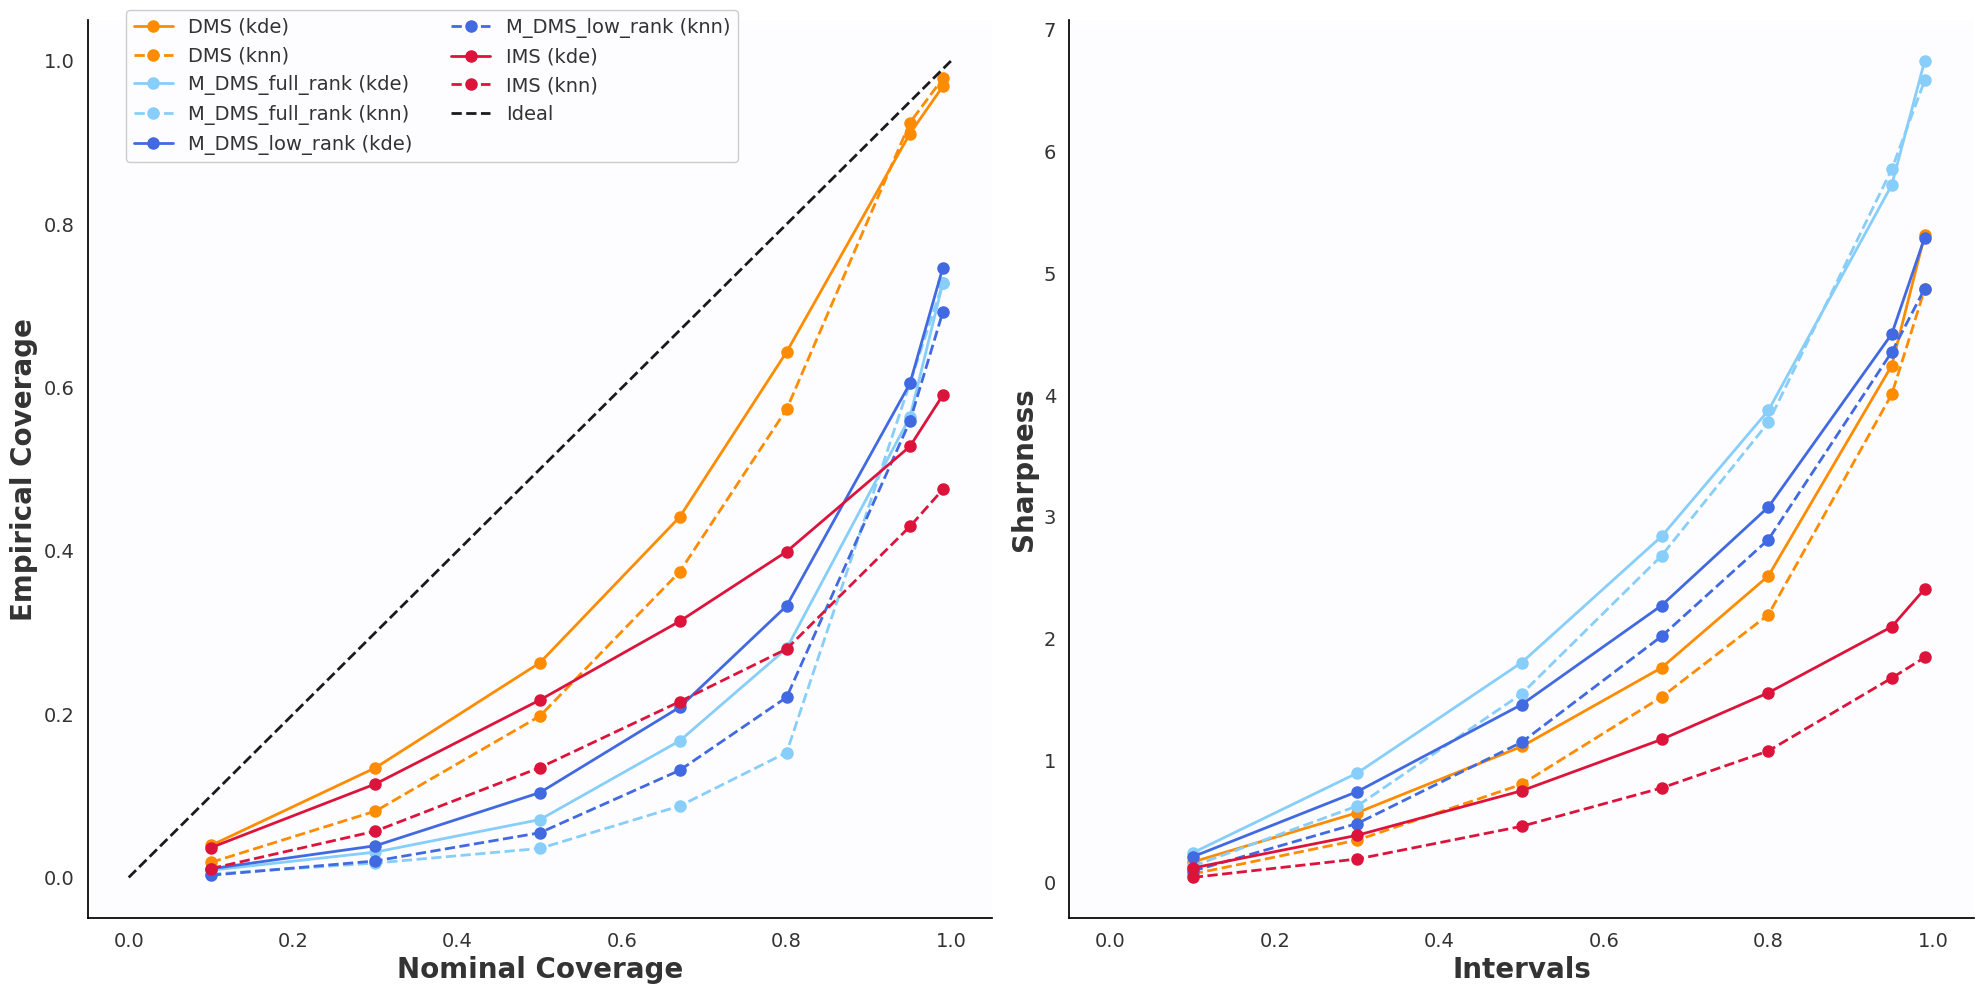

In [46]:
# Example interval bounds - replace with your actual interval_bounds
# interval_bounds = {50: 0.5, 67: 0.67, 95: 0.95, 99: 0.99}

# Extract nominal quantiles from the keys
quantile_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
# Nominal coverages = the quantile levels themselves
nominal_coverage = kde_levels # list(interval_bounds.values()) #quantile_levels

# Custom styling
custom_text_color = "#333333"
custom_bg = "#FDFDFF"
custom_theme = {
    'axes.facecolor': custom_bg,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#dcdcdc',
    'xtick.color': custom_text_color,
    'ytick.color': custom_text_color,
    'axes.labelcolor': custom_text_color,
    'text.color': custom_text_color
}

sns.set_theme(style='white')
sns.set_style("white", rc=custom_theme)

# Create subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 10), sharex=True)

# Color scheme
colors = {
    'DMS': "#FF8C00",     # DarkOrange – warm, vibrant
    'M_DMS': "#87CEFA",   # LightSkyBlue – cool contrast to DMS
    'M_DMS_2': "#4169E1", # RoyalBlue – deeper blue, works with LightSkyBlue
    'IMS': "#DC143C"      # Crimson – striking and stands apart from others
}

# Plot coverage (left subplot)
for model_name in ['DMS', 'M_DMS', 'M_DMS_2', 'IMS']:
    for mode in ['kde', 'knn']:
        empirical_coverage = [kde_results[model_name][f'{mode}_coverage_{q}'] for q in nominal_coverage]
        if mode == 'knn':
            linestyle = '--'
        else:
            linestyle = '-'
        if model_name == 'M_DMS':
            axs[0].plot(nominal_coverage, empirical_coverage, marker='o', color=colors[model_name], 
                       label=f'M_DMS_full_rank ({mode})', linewidth=2, markersize=8, linestyle=linestyle)
        elif model_name == 'M_DMS_2':
            axs[0].plot(nominal_coverage, empirical_coverage, marker='o', color=colors[model_name], 
                       label=f'M_DMS_low_rank ({mode})', linewidth=2, markersize=8, linestyle=linestyle)
        else:
            axs[0].plot(nominal_coverage, empirical_coverage, marker='o', color=colors[model_name], 
                       label=f'{model_name} ({mode})', linewidth=2, markersize=8, linestyle=linestyle)

# Add ideal diagonal line
axs[0].plot([0, 1], [0, 1], 'k--', label='Ideal', linewidth=2)
axs[0].set_xlabel("Nominal Coverage", fontsize=20, fontweight='bold')
axs[0].set_ylabel("Empirical Coverage", fontsize=20, fontweight='bold')

# Plot sharpness (right subplot)
for model_name in ['DMS', 'M_DMS', 'M_DMS_2', 'IMS']:
     for mode in ['kde', 'knn']:
        interval_scores = [kde_results[model_name][f'{mode}_sharpness_{q}'] for q in nominal_coverage]
        if mode == 'knn':
            linestyle = '--'
        else:
            linestyle = '-'
        if model_name == 'M_DMS':
            axs[1].plot(list(nominal_coverage), interval_scores, marker='o', 
                       color=colors[model_name], label=f'M_DMS_full_rank ({mode})', linewidth=2, markersize=8, linestyle=linestyle)
        elif model_name == 'M_DMS_2':
            axs[1].plot(list(nominal_coverage), interval_scores, marker='o', 
                       color=colors[model_name], label=f'M_DMS_low_rank ({mode})', linewidth=2, markersize=8, linestyle=linestyle)
        else:
            axs[1].plot(list(nominal_coverage), interval_scores, marker='o', 
                       color=colors[model_name], label=f'{model_name} ({mode})', linewidth=2, markersize=8, linestyle=linestyle)

axs[1].set_xlabel("Intervals", fontsize=20, fontweight='bold')
# axs[0].set_xlim(0.47, 1)
axs[1].set_ylabel("Sharpness", fontsize=20, fontweight='bold')

# Style both axes
for ax in axs:
    ax.tick_params(axis='both', labelsize=14)
    # ax.grid(True, alpha=0.3)

plt.tight_layout()
sns.despine(left=False, bottom=False)

# Add legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.22, 0.83), 
          fontsize=14, frameon=True, framealpha=1)

# Save and show
plt.savefig("Coverage_and_sharpness.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

In [12]:
samples_ims = results["ims"]["samples"].squeeze(1).numpy()
samples = results['ground_truth']['samples'][:, 60:]

from torch.distributions import Normal
import torch

def compute_dms(results):
    mu = results['dms']['mu']
    sigma = results['dms']['sigma']
    dist = Normal(torch.tensor(mu), torch.tensor(sigma))
    return dist.rsample((100,))

samples_dms = compute_dms(results).numpy()
print(samples_ims.shape, samples.shape, samples_dms.shape)

KeyError: 'ims'

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist
from sklearn.neighbors import KernelDensity
import numpy as np

def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    mmd = xx.mean() + yy.mean() - 2 * xy.mean()
    return mmd

def compute_energy_distance(x, y):
    d_xx = cdist(x, x, metric='euclidean')
    d_yy = cdist(y, y, metric='euclidean')
    d_xy = cdist(x, y, metric='euclidean')
    energy = 2 * d_xy.mean() - d_xx.mean() - d_yy.mean()
    return energy

def compute_kl_kde(samples_p, samples_q, bandwidth=1.0):
    kde_p = KernelDensity(bandwidth=bandwidth).fit(samples_p)
    kde_q = KernelDensity(bandwidth=bandwidth).fit(samples_q)
    log_p = kde_p.score_samples(samples_p)
    log_q = kde_q.score_samples(samples_p)
    return np.mean(log_p - log_q)  # KL(P || Q)

    
mmd = compute_mmd(samples, samples_ims)
energy = compute_energy_distance(samples, samples_ims)
kl = compute_kl_kde(samples, samples_ims)

print(f"MMD: {mmd:.4f}")
print(f"Energy Distance: {energy:.4f}")
print(f"KL Divergence (approx): {kl:.4f}")

mmd = compute_mmd(samples, samples_dms)
energy = compute_energy_distance(samples, samples_dms)
kl = compute_kl_kde(samples, samples_dms)

print(f"MMD: {mmd:.4f}")
print(f"Energy Distance: {energy:.4f}")
print(f"KL Divergence (approx): {kl:.4f}")


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Red lines: samples_ims
for i in range(samples_ims.shape[0]):
    axes[0].plot(range(samples_ims.shape[1]), samples_ims[i, :], color='red', alpha=0.1)
axes[0].set_title('samples_ims')

# Green lines: samples
for i in range(samples.shape[0]):
    axes[1].plot(range(samples.shape[1]), samples[i, :], color='green', alpha=0.1)
axes[1].set_title('samples')

# Blue lines: samples_dms
for i in range(samples_dms.shape[0]):
    axes[2].plot(range(samples_dms.shape[1]), samples_dms[i, :], color='blue', alpha=0.1)
axes[2].set_title('samples_dms')

for ax in axes:
    ax.set_xlabel('Dimension')
axes[0].set_ylabel('Value')

plt.tight_layout()
plt.show()
